# Import Data & Libraries


Data source: https://www.kaggle.com/datasets/kartik2112/fraud-detection
Took a sample of 50,000 from the "test" dataset, using:
df_sample, df_sample_95 = train_test_split(df, test_size=0.95, stratify=df['is_fraud'], random_state=42). Our dataset is the 5% sample.

In [336]:
#library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

In [337]:
#import data
df = pd.read_csv("fraud.csv")
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,417308,2020-12-01 05:38:34,348789608637806,fraud_Berge LLC,gas_transport,50.420,Megan,Murphy,F,53696 Laura Radial,Holstein,NE,68950,40.454,-98.654,331,Telecommunications researcher,1950-08-19,dc152cdac86b839b6f535b96b249bdd5,1385876314,40.000,-99.040,0
1,22343,2020-06-29 02:05:06,2291163933867244,"fraud_Bins, Balistreri and Beatty",shopping_pos,39.470,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.966,-80.936,333497,Mechanical engineer,1968-03-19,254f731157566c1129d88b1fec57ea9d,1372471506,33.547,-80.976,0
2,540530,2020-12-28 15:48:07,372509258176510,"fraud_Bradtke, Torp and Bahringer",personal_care,8.160,Kristen,Hanson,F,26544 Andrea Glen,Goodrich,MI,48438,42.915,-83.484,6951,Learning disability nurse,1985-06-18,cdef45931b53a75bf09e3ea265df817c,1388245687,43.651,-84.041,0
3,492286,2020-12-17 23:47:28,571365235126,"fraud_Prosacco, Kreiger and Kovacek",home,25.480,Barbara,Taylor,F,0069 Robin Brooks Apt. 695,Elberta,MI,49628,44.599,-86.214,372,"Exhibitions officer, museum/gallery",1995-07-12,15b1835cfe2cef056258d83a71e1d6f3,1387324048,44.948,-85.290,0
4,17203,2020-06-27 11:52:35,4225990116481262579,"fraud_Bernier, Volkman and Hoeger",misc_net,5.710,Brian,Simpson,M,2711 Duran Pines,Honokaa,HI,96727,20.083,-155.488,4878,Physiotherapist,1966-12-03,10b26afaa3610fe336b15e95522b3390,1372333955,19.658,-156.016,0


# Exploratory Data Analysis

## Basic Data Information

In [340]:
#get shape
df.shape

(27785, 23)

In [341]:
#are there duplicates?
df.duplicated().sum()

0

In [342]:
#get datatypes
df.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [343]:
# is there class imbalance?
df['is_fraud'].value_counts()

is_fraud
0    27678
1      107
Name: count, dtype: int64

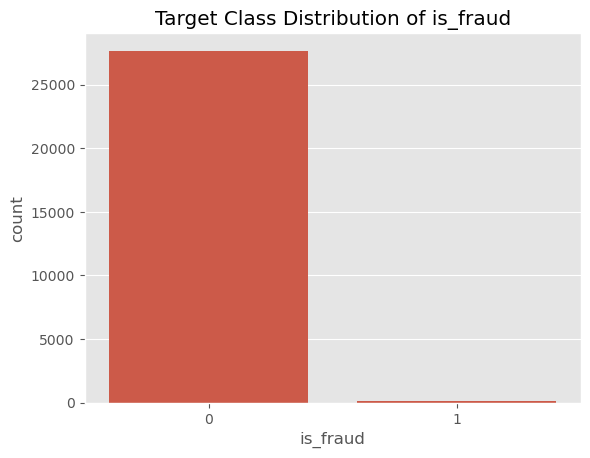

In [344]:
sns.countplot(x='is_fraud', data=df)
plt.title('Target Class Distribution of is_fraud')
plt.show()

In [345]:
#percentage of binary class
print("percentage of each class", df['is_fraud'].value_counts()/len(df)*100)

percentage of each class is_fraud
0   99.615
1    0.385
Name: count, dtype: float64


## Data Quality Report

### Continuous Features

In [348]:
# identify continuous features
conf = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
conf

['Unnamed: 0',
 'cc_num',
 'amt',
 'zip',
 'lat',
 'long',
 'city_pop',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud']

In [349]:
#identify any columns to filter out from the "continuous features"
conf_exclude = ['Unnamed: 0', 'cc_num'] #excluding unamned as that is just the row #, and excluding credit card # as that is an ID
filter_conf = [x for x in conf if x not in conf_exclude]
filter_conf

['amt',
 'zip',
 'lat',
 'long',
 'city_pop',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud']

In [350]:
#get summary stats on continuous
pd.set_option('display.float_format', '{:.2f}'.format)
df[filter_conf].describe()

,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,27785.00,27785.00,27785.00,27785.00,27785.00,27785.00,27785.00,27785.00,27785.00
mean,68.28,48733.84,38.53,-90.17,86906.27,1380671597.50,38.53,-90.17,0.00
std,136.20,26895.98,5.03,13.64,290698.32,5194009.36,5.07,13.66,0.06
min,1.00,1257.00,20.03,-165.67,23.00,1371816893.00,19.03,-166.67,0.00
25%,9.52,26041.00,34.67,-96.79,743.00,1376061884.00,34.78,-96.86,0.00
50%,47.23,48174.00,39.37,-87.46,2456.00,1380691607.00,39.40,-87.40,0.00
75%,82.90,72011.00,41.89,-80.16,20328.00,1385862997.00,41.96,-80.18,0.00
max,8517.38,99783.00,65.69,-67.95,2906700.00,1388534055.00,66.67,-66.99,1.00


In [351]:
pd.options.display.float_format = '{:.3f}'.format 

data_quality_conf = pd.DataFrame({
    'Feature': filter_conf,
    'Count': df[filter_conf].count().values,
    'Missing Values': df[filter_conf].isnull().sum().values,
    'Cardinality': df[filter_conf].nunique().values,
    'Min': df[filter_conf].min().values,
    '1st Quartile': df[filter_conf].quantile(0.25).values,
    'Mean': df[filter_conf].mean().values,
    'Median': df[filter_conf].median().values,
    '3rd Quartile': df[filter_conf].quantile(0.75).values,
    'Max': df[filter_conf].max().values,
    'Standard Deviation': df[filter_conf].std().values,
})
print("Data Quality Report - Continuous Features")
data_quality_conf

Data Quality Report - Continuous Features


,Feature,Count,Missing Values,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Standard Deviation
0,amt,27785,0,12365,1.000,9.520,68.285,47.230,82.900,8517.380,136.198
1,zip,27785,0,900,1257.000,26041.000,48733.838,48174.000,72011.000,99783.000,26895.975
2,lat,27785,0,898,20.027,34.669,38.532,39.372,41.895,65.690,5.034
3,long,27785,0,899,-165.672,-96.787,-90.174,-87.458,-80.158,-67.950,13.643
4,city_pop,27785,0,825,23.000,743.000,86906.268,2456.000,20328.000,2906700.000,290698.323
5,unix_time,27785,0,27758,1371816893.000,1376061884.000,1380671597.499,1380691607.000,1385862997.000,1388534055.000,5194009.361
6,merch_lat,27785,0,27767,19.027,34.776,38.534,39.402,41.955,66.672,5.069
7,merch_long,27785,0,27774,-166.670,-96.856,-90.171,-87.400,-80.182,-66.985,13.658
8,is_fraud,27785,0,2,0.000,0.000,0.004,0.000,0.000,1.000,0.062


### Categorical Features

In [353]:
#identify any categorical features
catf = df.select_dtypes(include=['object']).columns.tolist()
catf

['trans_date_trans_time',
 'merchant',
 'category',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'job',
 'dob',
 'trans_num']

In [354]:
#identify any columns to filter out from the "categorical features"
catf_exclude = ['trans_num'] #excluding transaction number as that is an ID
filter_catf = [x for x in catf if x not in catf_exclude]
filter_catf

['trans_date_trans_time',
 'merchant',
 'category',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'job',
 'dob']

In [355]:
#create lists to store modes & frequencies
modes = []
mode_freqs = []
second_modes = []
second_mode_freqs = []
mode_percentages = []
second_mode_percentages = []

In [356]:
# Calculate mode and frequency for each categorical feature
for feature in filter_catf:
    count = df[feature].count()
    mode = df[feature].mode().iloc[0]
    mode_freq = df[feature].value_counts().iloc[0]
    modes.append(mode)
    mode_freqs.append(mode_freq)
    mode_percentages.append((mode_freq / count) * 100 if count > 0 else 0)

    # Calculate second mode and its frequency
    if len(df[feature].value_counts()) > 1:
        second_mode = df[feature].value_counts().index[1]
        second_mode_freq = df[feature].value_counts().iloc[1]
    else:
        second_mode = None
        second_mode_freq = 0

    second_modes.append(second_mode)
    second_mode_freqs.append(second_mode_freq)
    second_mode_percentages.append((second_mode_freq / count) * 100 if count > 0 else 0)

In [357]:
#build quality report table
data_quality_catf = pd.DataFrame({
    'Feature': filter_catf,
    'Count': df[filter_catf].count().values,
    'Missing Values': df[filter_catf].isnull().sum().values,
    'Cardinality': df[filter_catf].nunique().values,
    'Mode':modes,
    'Mode Frequency':mode_freqs,
    'Mode %': mode_percentages,
    '2nd Mode':second_modes,
    '2nd Mode Frequency': second_mode_freqs,
    '2nd Mode %': second_mode_percentages,
})
print("Data Quality Report - Categorical Features")
data_quality_catf

Data Quality Report - Categorical Features


,Feature,Count,Missing Values,Cardinality,Mode,Mode Frequency,Mode %,2nd Mode,2nd Mode Frequency,2nd Mode %
0,trans_date_trans_time,27785,0,27758,2020-06-21 19:09:47,2,0.007,2020-10-05 19:37:49,2,0.007
1,merchant,27785,0,693,fraud_Dickinson Ltd,84,0.302,fraud_Dickinson Ltd,84,0.302
2,category,27785,0,14,gas_transport,2820,10.149,grocery_pos,2601,9.361
3,first,27785,0,339,Christopher,573,2.062,Robert,460,1.656
4,last,27785,0,465,Smith,638,2.296,Williams,481,1.731
5,gender,27785,0,2,F,15252,54.893,M,12533,45.107
6,street,27785,0,911,6983 Carrillo Isle,86,0.310,908 Brooks Brook,84,0.302
7,city,27785,0,839,Birmingham,140,0.504,Meridian,112,0.403
8,state,27785,0,50,TX,2006,7.220,NY,1851,6.662
9,job,27785,0,476,Film/video editor,206,0.741,"Surveyor, land/geomatics",203,0.731


## Univariate Analysis

In [359]:
filter_catf2 = ['merchant','category', 'gender', 'job']

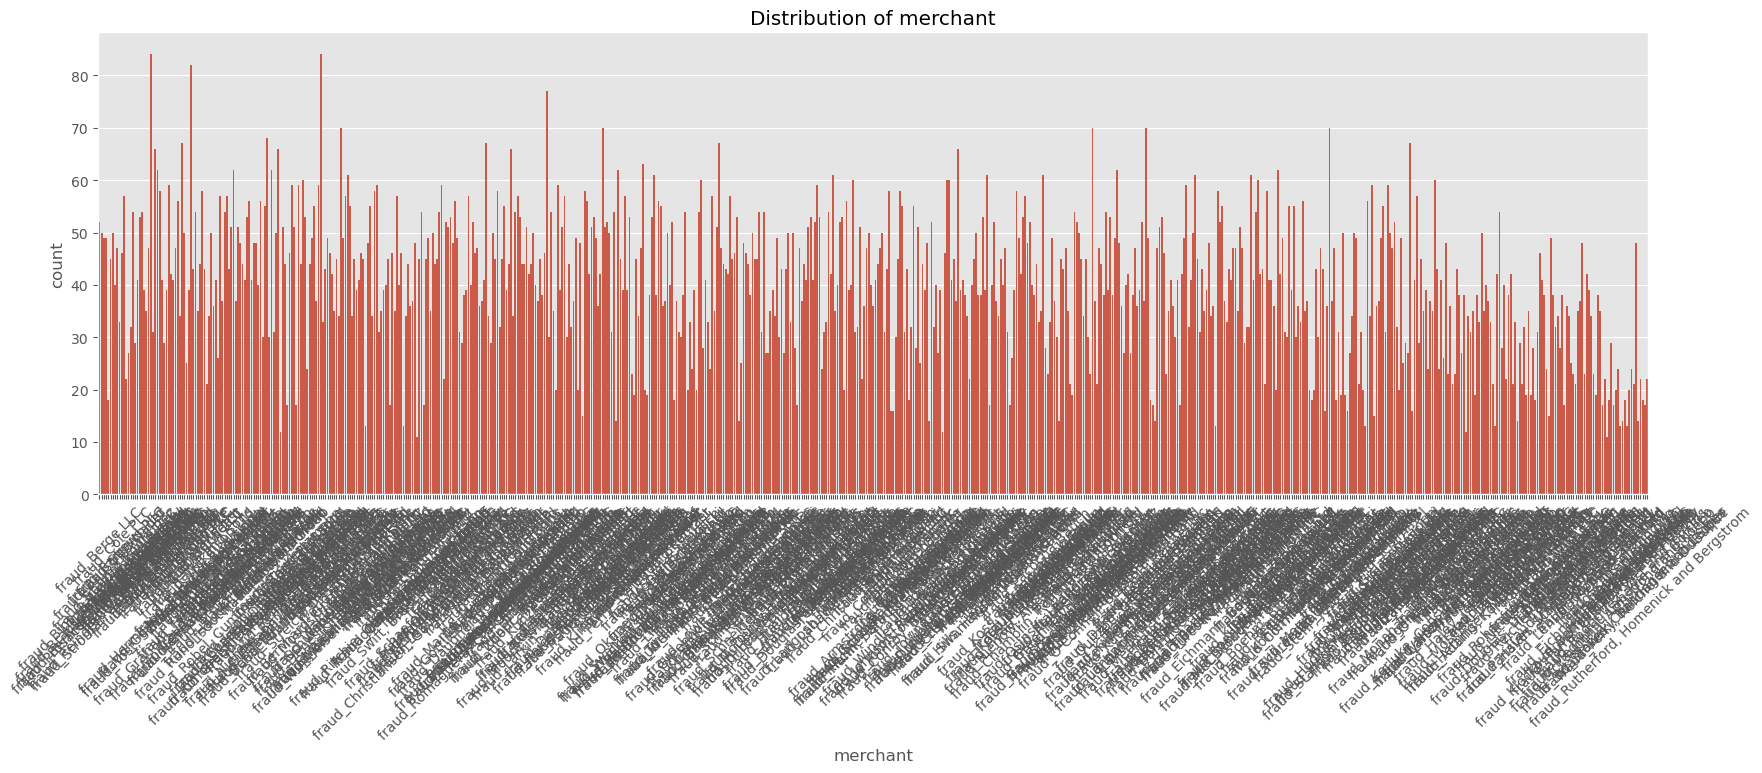

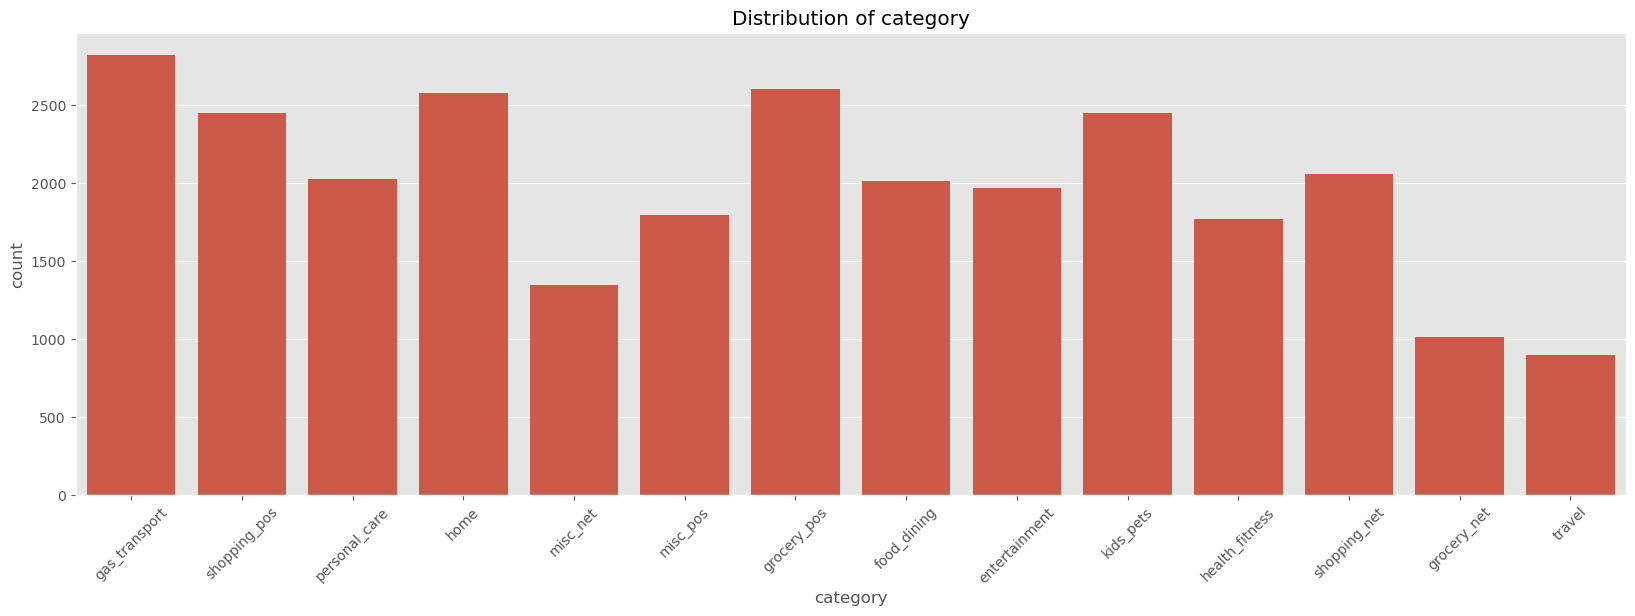

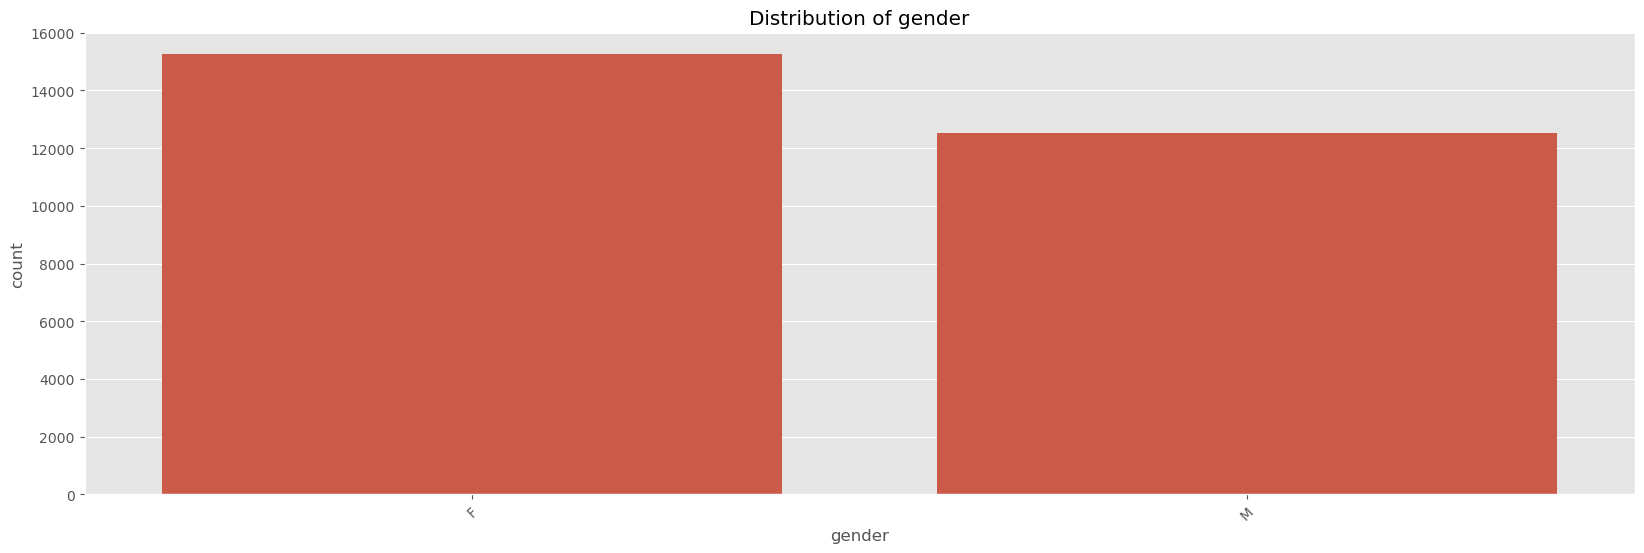

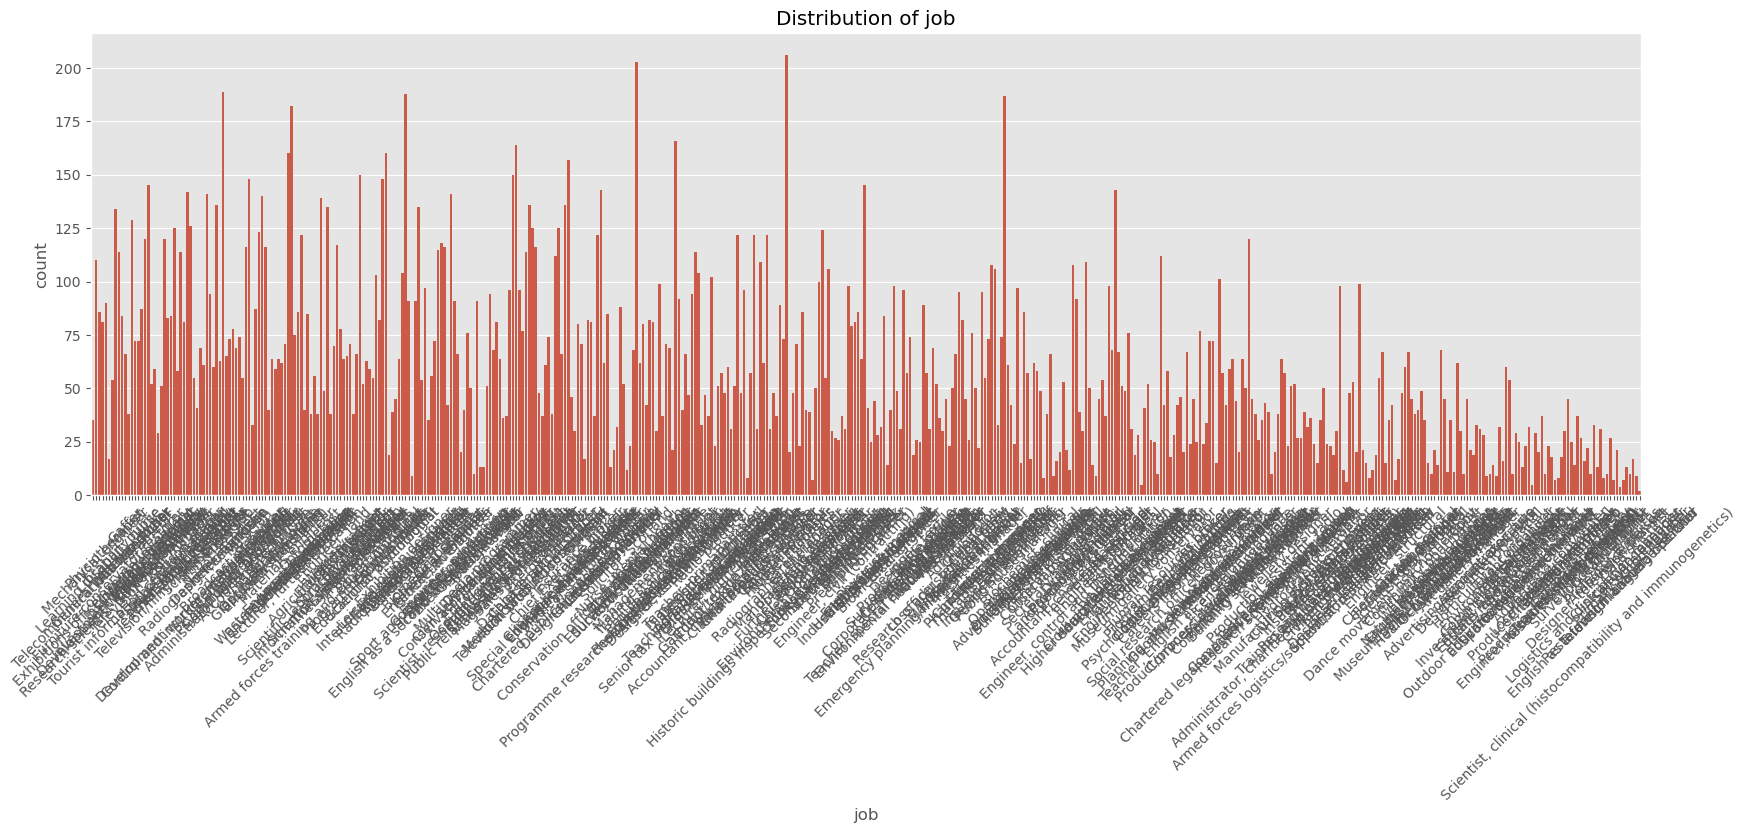

In [360]:
#plot the categorical variables
plt.style.use('ggplot')

for column in filter_catf2:
    plt.figure(figsize=(20, 6))
    sns.countplot(x=column, data=df)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation =45)
    plt.show()

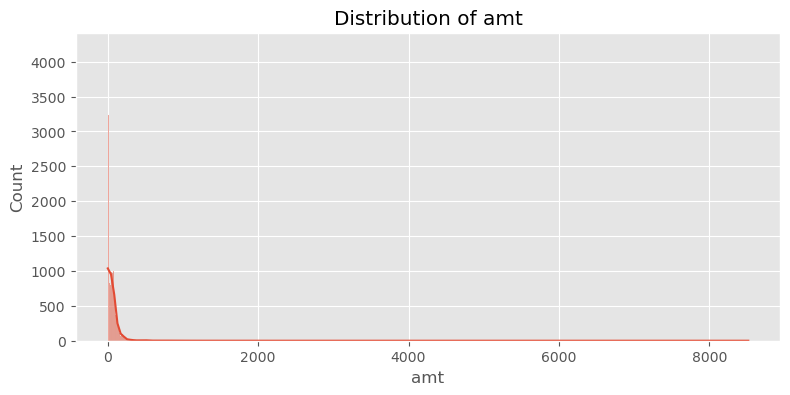

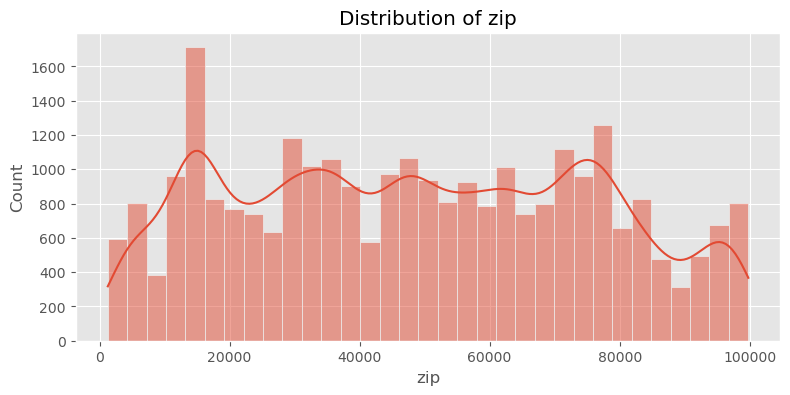

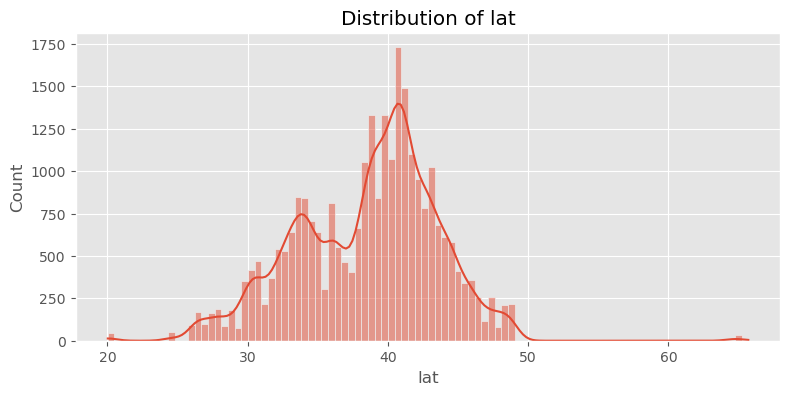

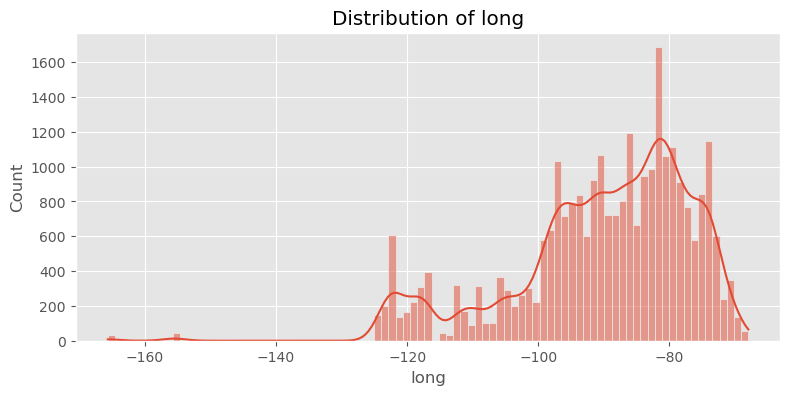

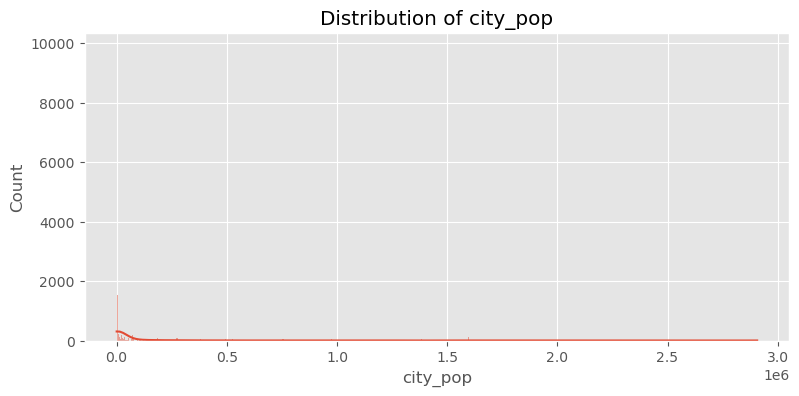

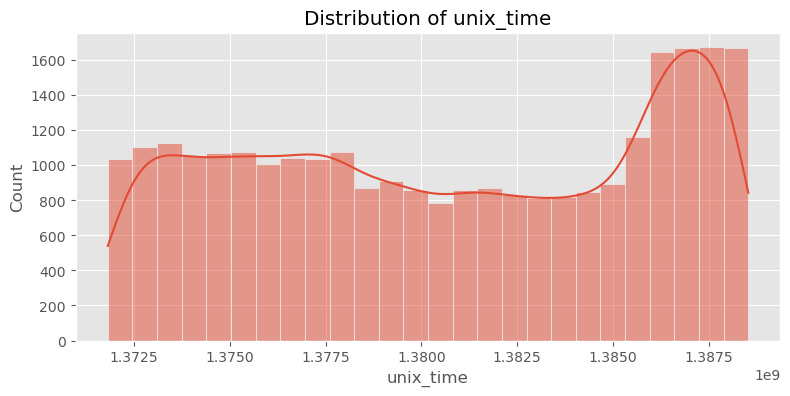

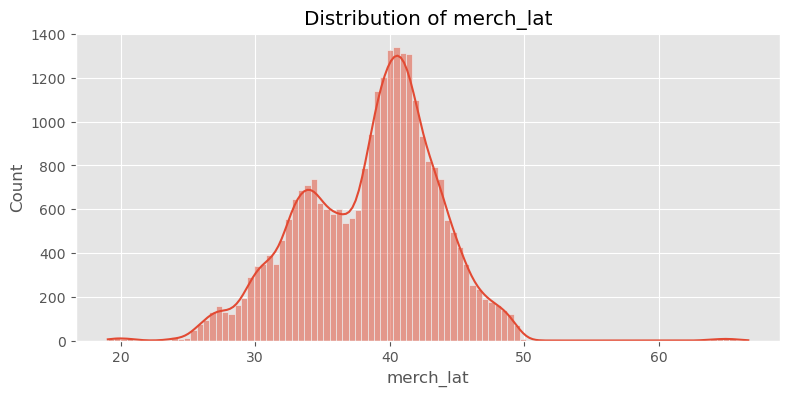

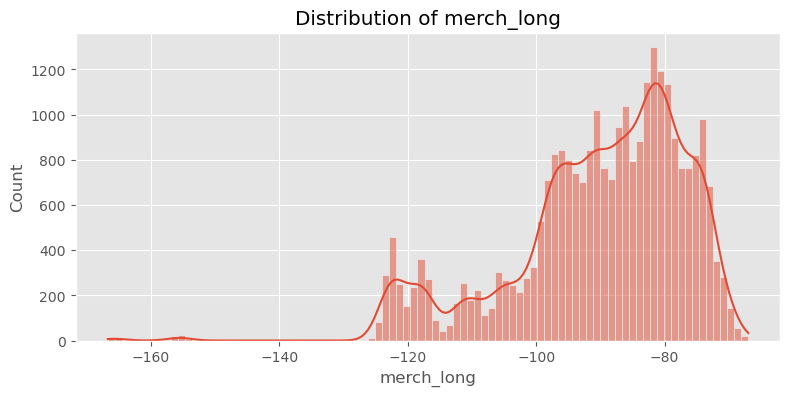

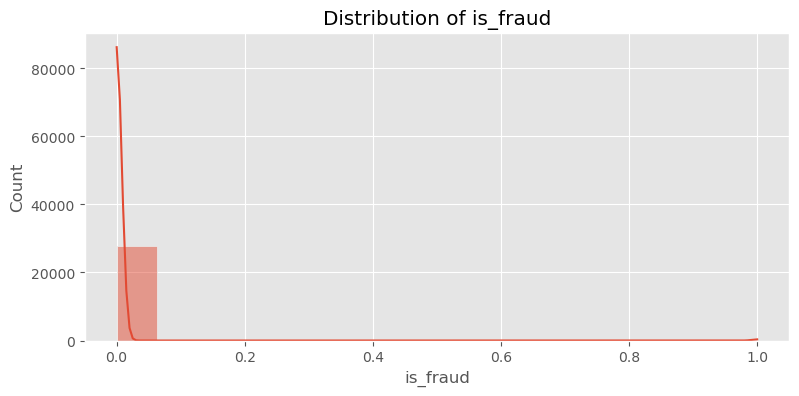

In [361]:
#plot histograms for numerical variables
plt.style.use('ggplot')
for column in filter_conf:
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde = True)
    plt.title(f'Distribution of {column}')
    plt.show()

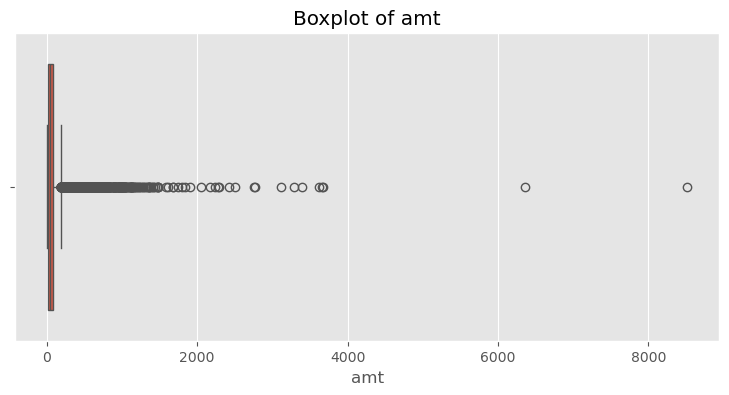

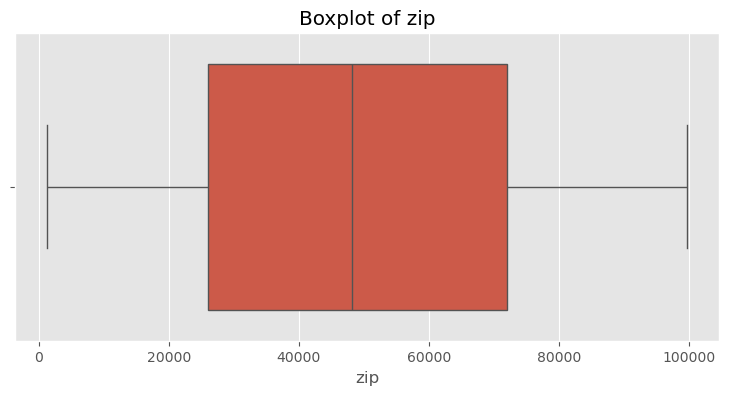

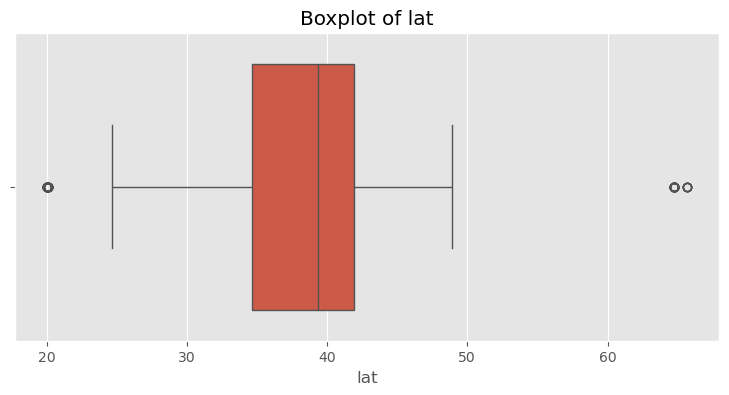

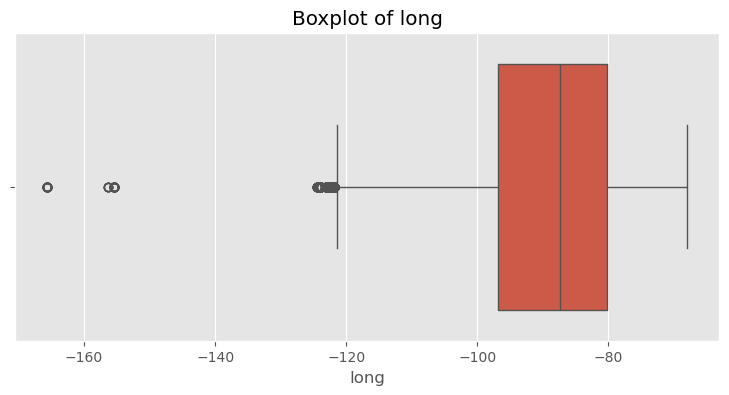

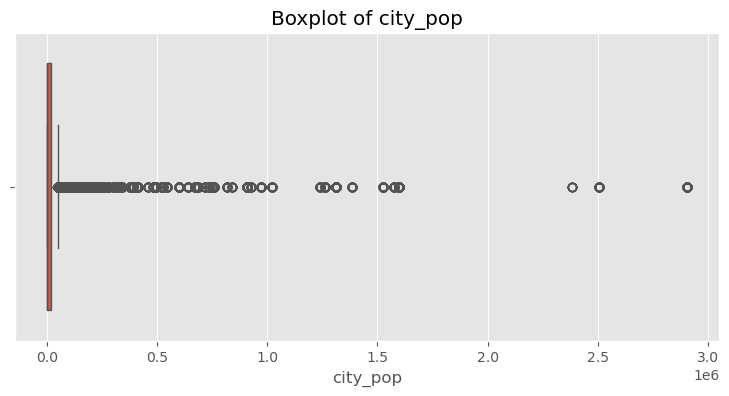

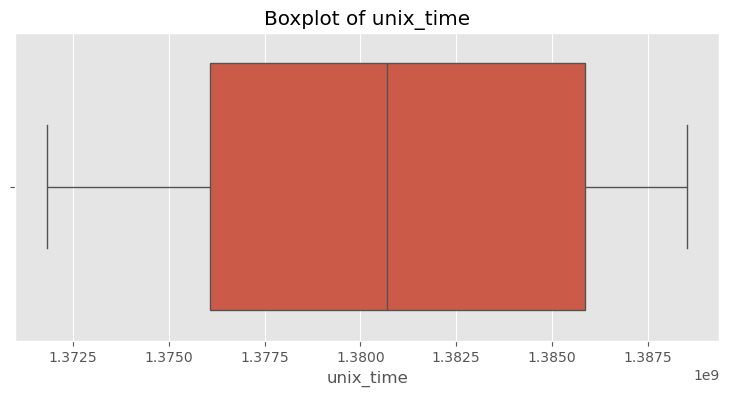

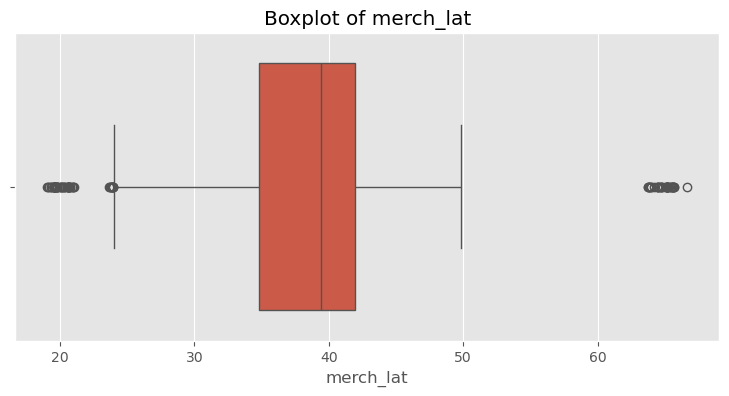

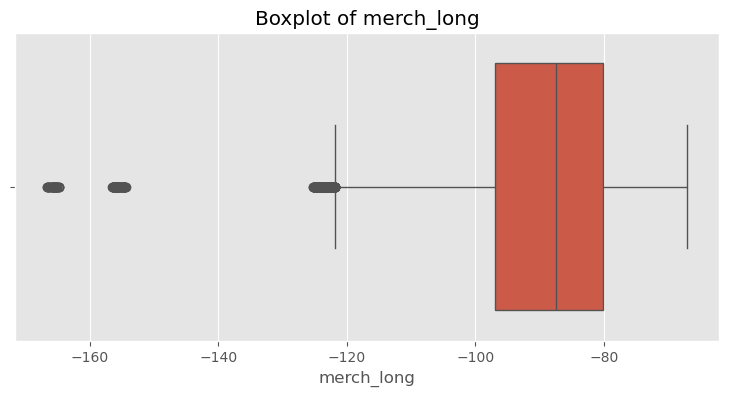

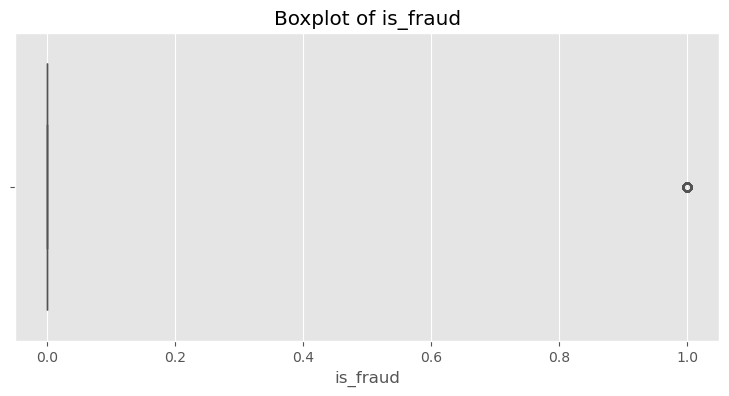

In [362]:
#plot boxplots of all continuous features
plt.style.use('ggplot')
for column in filter_conf:
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

## Multivariate Analysis

### Correlations

In [365]:
#correlations
corr_matrix = df[filter_conf].corr()
corr_matrix

,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
amt,1.000,0.008,0.006,-0.008,0.003,-0.002,0.007,-0.008,0.206
zip,0.008,1.000,-0.122,-0.912,0.080,-0.003,-0.121,-0.911,-0.002
lat,0.006,-0.122,1.000,-0.007,-0.147,0.002,0.993,-0.006,0.014
long,-0.008,-0.912,-0.007,1.000,-0.059,0.001,-0.007,0.999,-0.003
city_pop,0.003,0.080,-0.147,-0.059,1.000,-0.007,-0.146,-0.059,-0.010
unix_time,-0.002,-0.003,0.002,0.001,-0.007,1.000,0.001,0.001,-0.010
merch_lat,0.007,-0.121,0.993,-0.007,-0.146,0.001,1.000,-0.007,0.015
merch_long,-0.008,-0.911,-0.006,0.999,-0.059,0.001,-0.007,1.000,-0.003
is_fraud,0.206,-0.002,0.014,-0.003,-0.010,-0.010,0.015,-0.003,1.000


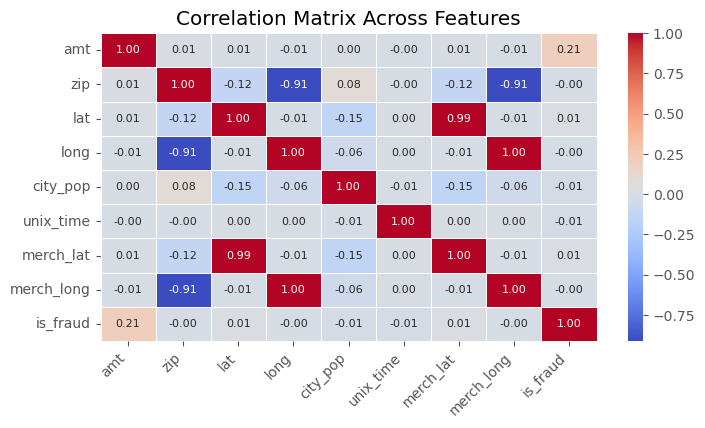

In [366]:
# Create a heatmap
plt.figure(figsize=(8, 4))
heatmap = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})

# Rotate the x and y labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Show the heatmap
plt.title("Correlation Matrix Across Features")
plt.show()

In [367]:
#identify most highly correlated items to the target variable
target_column = 'is_fraud'
corr_with_target = corr_matrix[target_column].abs() #get the absolute value of features correlation to target variable
threshold = .01 #set the threshold for correlation
high_corr = corr_with_target[corr_with_target > threshold].index.tolist() #gets the list of features that meet threshold
print(high_corr)

['amt', 'lat', 'city_pop', 'merch_lat', 'is_fraud']


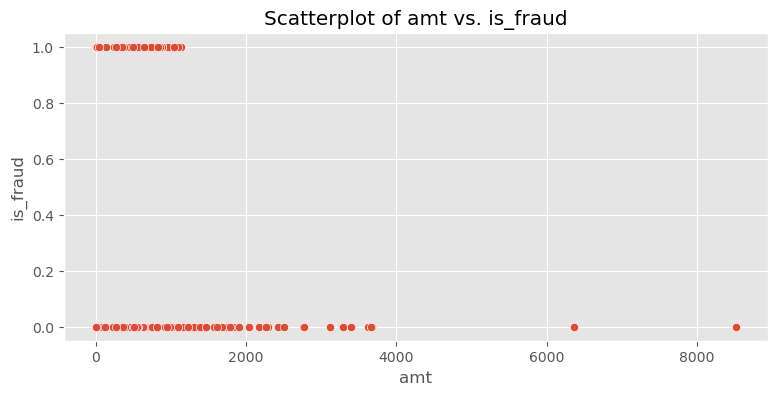

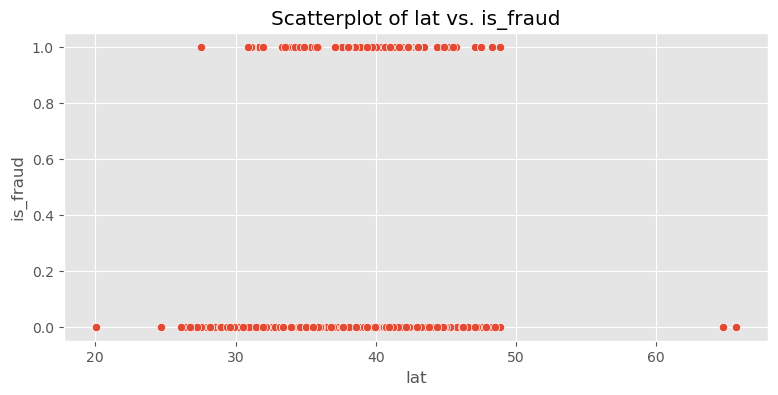

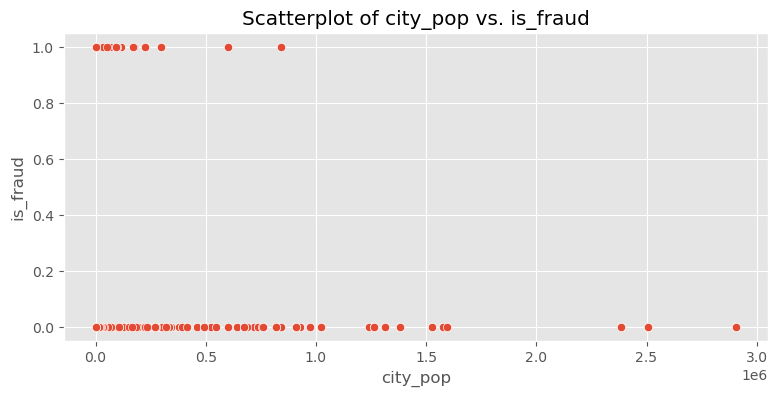

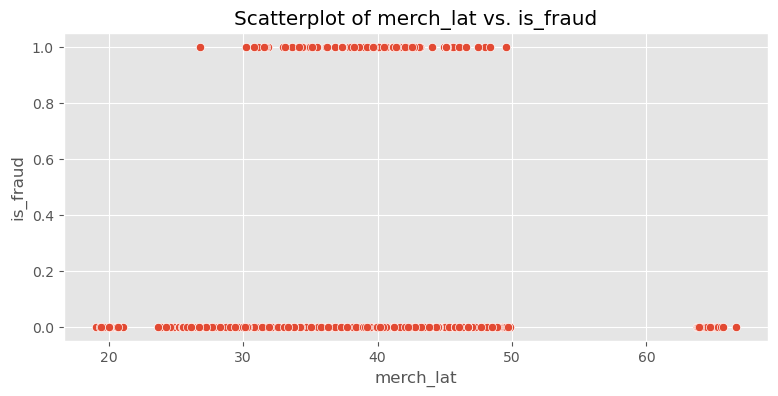

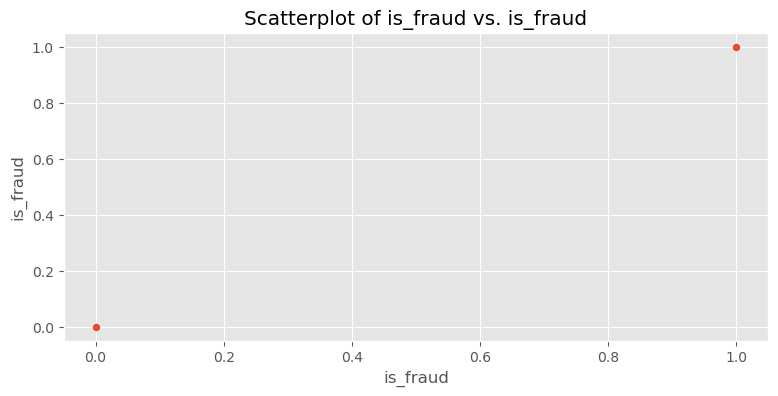

In [368]:
#plot scatterplots for threshold meeting the correlation
plt.style.use('ggplot')
for column in high_corr:
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=df[column], y=df['is_fraud'])
    plt.title(f'Scatterplot of {column} vs. is_fraud')
    plt.show()

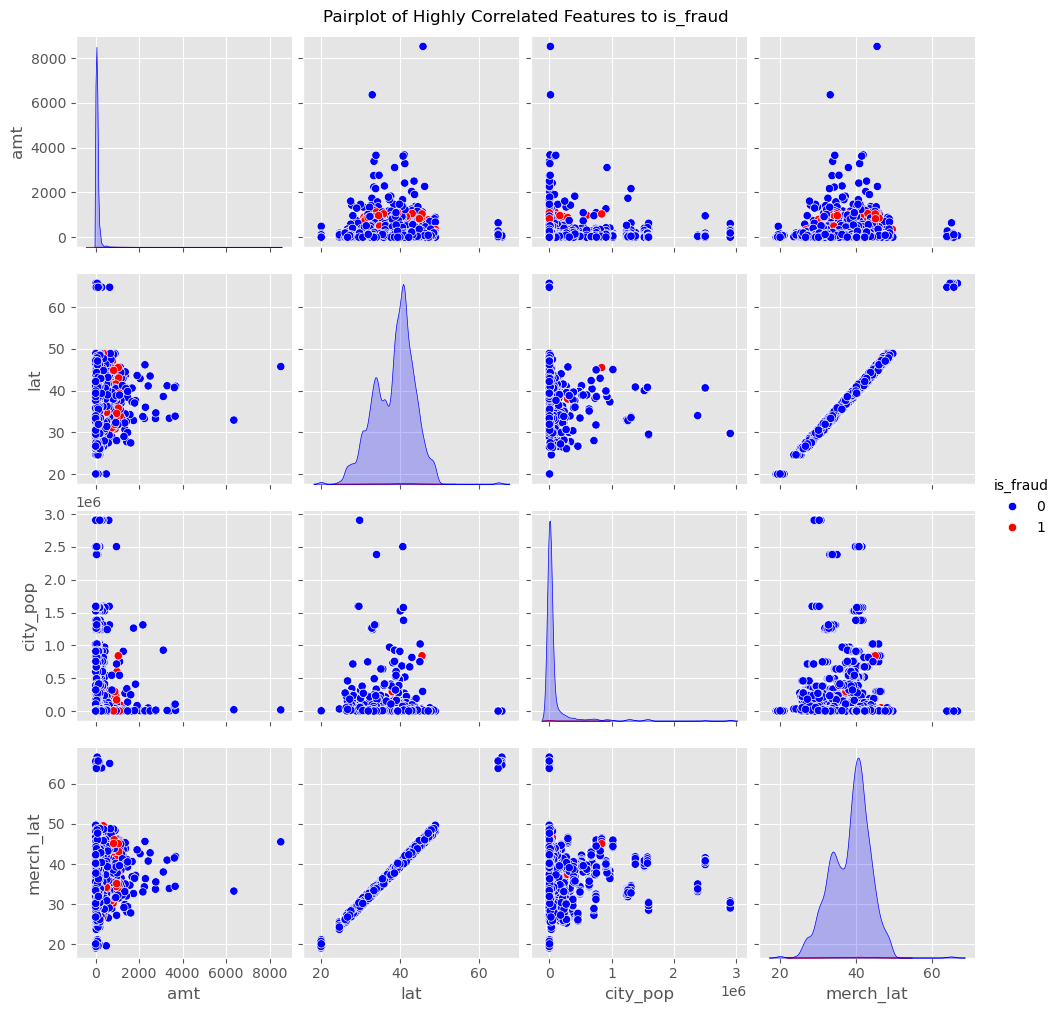

In [369]:
sns.pairplot(df[high_corr], hue='is_fraud', palette={1: 'red', 0: 'blue'})
plt.suptitle("Pairplot of Highly Correlated Features to is_fraud",y= 1.01) #ensures that it isn't on top of graphs
plt.show()

# Data Pre-Processing

In [371]:
df1 = df.copy()

In [372]:
df1.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,417308,2020-12-01 05:38:34,348789608637806,fraud_Berge LLC,gas_transport,50.420,Megan,Murphy,F,53696 Laura Radial,Holstein,NE,68950,40.454,-98.654,331,Telecommunications researcher,1950-08-19,dc152cdac86b839b6f535b96b249bdd5,1385876314,40.000,-99.040,0
1,22343,2020-06-29 02:05:06,2291163933867244,"fraud_Bins, Balistreri and Beatty",shopping_pos,39.470,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.966,-80.936,333497,Mechanical engineer,1968-03-19,254f731157566c1129d88b1fec57ea9d,1372471506,33.547,-80.976,0
2,540530,2020-12-28 15:48:07,372509258176510,"fraud_Bradtke, Torp and Bahringer",personal_care,8.160,Kristen,Hanson,F,26544 Andrea Glen,Goodrich,MI,48438,42.915,-83.484,6951,Learning disability nurse,1985-06-18,cdef45931b53a75bf09e3ea265df817c,1388245687,43.651,-84.041,0
3,492286,2020-12-17 23:47:28,571365235126,"fraud_Prosacco, Kreiger and Kovacek",home,25.480,Barbara,Taylor,F,0069 Robin Brooks Apt. 695,Elberta,MI,49628,44.599,-86.214,372,"Exhibitions officer, museum/gallery",1995-07-12,15b1835cfe2cef056258d83a71e1d6f3,1387324048,44.948,-85.290,0
4,17203,2020-06-27 11:52:35,4225990116481262579,"fraud_Bernier, Volkman and Hoeger",misc_net,5.710,Brian,Simpson,M,2711 Duran Pines,Honokaa,HI,96727,20.083,-155.488,4878,Physiotherapist,1966-12-03,10b26afaa3610fe336b15e95522b3390,1372333955,19.658,-156.016,0


## Feature Transformation - Distance

In [374]:
import math
#haversine formula calculates the difference between two points. Tutorial here:
#https://www.geeksforgeeks.org/haversine-formula-to-find-distance-between-two-points-on-a-sphere/

#create haversine function
def haversine(lat1, lon1, lat2, lon2):
    # distance between latitudes and longitudes
    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (lon2 - lon1) * math.pi / 180.0

    # convert to radians
    lat1 = lat1 * math.pi / 180.0
    lat2 = lat2 * math.pi / 180.0

    # apply formula
    a = (pow(math.sin(dLat / 2), 2) +
         pow(math.sin(dLon / 2), 2) *
         math.cos(lat1) * math.cos(lat2))
    rad = 6371  # Earth’s radius in kilometers
    c = 2 * math.asin(math.sqrt(a))
    return rad * c

df1['distance_km'] = df1.apply(lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)

# Display the updated dataframe with the distance column
print(df1[['lat', 'long', 'merch_lat', 'merch_long', 'distance_km']])

         lat     long  merch_lat  merch_long  distance_km
0     40.454  -98.654     40.000     -99.040       60.200
1     33.966  -80.936     33.547     -80.976       46.722
2     42.915  -83.484     43.651     -84.041       93.483
3     44.599  -86.214     44.948     -85.290       82.612
4     20.083 -155.488     19.658    -156.016       72.611
...      ...      ...        ...         ...          ...
27780 31.957  -98.966     31.894     -99.870       85.625
27781 39.372  -77.823     40.371     -77.906      111.349
27782 39.935  -86.163     39.986     -86.364       18.056
27783 42.189  -74.923     42.298     -74.987       13.216
27784 39.406  -75.321     40.162     -75.233       84.435

[27785 rows x 5 columns]


In [375]:
df1.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,distance_km
0,417308,2020-12-01 05:38:34,348789608637806,fraud_Berge LLC,gas_transport,50.420,Megan,Murphy,F,53696 Laura Radial,Holstein,NE,68950,40.454,-98.654,331,Telecommunications researcher,1950-08-19,dc152cdac86b839b6f535b96b249bdd5,1385876314,40.000,-99.040,0,60.200
1,22343,2020-06-29 02:05:06,2291163933867244,"fraud_Bins, Balistreri and Beatty",shopping_pos,39.470,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.966,-80.936,333497,Mechanical engineer,1968-03-19,254f731157566c1129d88b1fec57ea9d,1372471506,33.547,-80.976,0,46.722
2,540530,2020-12-28 15:48:07,372509258176510,"fraud_Bradtke, Torp and Bahringer",personal_care,8.160,Kristen,Hanson,F,26544 Andrea Glen,Goodrich,MI,48438,42.915,-83.484,6951,Learning disability nurse,1985-06-18,cdef45931b53a75bf09e3ea265df817c,1388245687,43.651,-84.041,0,93.483
3,492286,2020-12-17 23:47:28,571365235126,"fraud_Prosacco, Kreiger and Kovacek",home,25.480,Barbara,Taylor,F,0069 Robin Brooks Apt. 695,Elberta,MI,49628,44.599,-86.214,372,"Exhibitions officer, museum/gallery",1995-07-12,15b1835cfe2cef056258d83a71e1d6f3,1387324048,44.948,-85.290,0,82.612
4,17203,2020-06-27 11:52:35,4225990116481262579,"fraud_Bernier, Volkman and Hoeger",misc_net,5.710,Brian,Simpson,M,2711 Duran Pines,Honokaa,HI,96727,20.083,-155.488,4878,Physiotherapist,1966-12-03,10b26afaa3610fe336b15e95522b3390,1372333955,19.658,-156.016,0,72.611


## DOB Transformation

Transform DOB to be the following generation numbers: 

*   Silent Generation: Born before 1945 : 0
*   Baby Boomers: 1946–1964 : 1
*   Generation X: 1965–1980 : 2
*   Millennials (Gen Y): 1981–1996 : 3
*   Generation Z (Gen Z): 1997–2012 : 4
*   Generation Alpha: 2013 and later : 5

In [378]:
# Convert 'DOB' column to datetime format
df1['dob'] = pd.to_datetime(df1['dob'], format='%Y-%m-%d')

# Function to categorize generations into numerical format
def categorize_generation(dob):
    if dob < pd.Timestamp('1945-01-01'):
        return 0  # Silent Generation
    elif dob < pd.Timestamp('1965-01-01'):
        return 1  # Baby Boomers
    elif dob < pd.Timestamp('1981-01-01'):
        return 2  # Generation X
    elif dob < pd.Timestamp('1997-01-01'):
        return 3  # Millennials
    elif dob < pd.Timestamp('2013-01-01'):
        return 4  # Generation Z
    else:
        return 5  # Generation Alpha

# Apply the function to create a new column for generations in numerical format
df1['Generation_Numeric'] = df1['dob'].apply(categorize_generation)

# Drop the original 'DOB' column
df1.drop(columns=['dob'], inplace=True)

# Display the updated DataFrame
df1.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,distance_km,Generation_Numeric
0,417308,2020-12-01 05:38:34,348789608637806,fraud_Berge LLC,gas_transport,50.420,Megan,Murphy,F,53696 Laura Radial,Holstein,NE,68950,40.454,-98.654,331,Telecommunications researcher,dc152cdac86b839b6f535b96b249bdd5,1385876314,40.000,-99.040,0,60.200,1
1,22343,2020-06-29 02:05:06,2291163933867244,"fraud_Bins, Balistreri and Beatty",shopping_pos,39.470,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.966,-80.936,333497,Mechanical engineer,254f731157566c1129d88b1fec57ea9d,1372471506,33.547,-80.976,0,46.722,2
2,540530,2020-12-28 15:48:07,372509258176510,"fraud_Bradtke, Torp and Bahringer",personal_care,8.160,Kristen,Hanson,F,26544 Andrea Glen,Goodrich,MI,48438,42.915,-83.484,6951,Learning disability nurse,cdef45931b53a75bf09e3ea265df817c,1388245687,43.651,-84.041,0,93.483,3
3,492286,2020-12-17 23:47:28,571365235126,"fraud_Prosacco, Kreiger and Kovacek",home,25.480,Barbara,Taylor,F,0069 Robin Brooks Apt. 695,Elberta,MI,49628,44.599,-86.214,372,"Exhibitions officer, museum/gallery",15b1835cfe2cef056258d83a71e1d6f3,1387324048,44.948,-85.290,0,82.612,3
4,17203,2020-06-27 11:52:35,4225990116481262579,"fraud_Bernier, Volkman and Hoeger",misc_net,5.710,Brian,Simpson,M,2711 Duran Pines,Honokaa,HI,96727,20.083,-155.488,4878,Physiotherapist,10b26afaa3610fe336b15e95522b3390,1372333955,19.658,-156.016,0,72.611,2


## City Population Transformation

Transforming city_pop to

https://www.oecd.org/en/data/indicators/urban-population-by-city-size.html?oecdcontrol-38c744bfa4-var1=USA%7COAVG

*   large metropolitan areas if they have a population of 1.5 million or more;
*   metropolitan areas if their population is between 500 000 and 1.5 million;
*   medium-size urban areas if their population is between 200 000 and 500 000;
*   small urban areas if their population is between 50 000 and 200 000.





In [381]:
# Define a function to categorize city populations based on OECD standards
def categorize_city_pop_oecd(city_pop):
    if city_pop >= 1500000:
        return 'Large Metropolitan Area'
    elif 500000 <= city_pop < 1500000:
        return 'Metropolitan Area'
    elif 200000 <= city_pop < 500000:
        return 'Medium-Size Urban Area'
    elif 50000 <= city_pop < 200000:
        return 'Small Urban Area'
    else:
        return 'Rural Area'

# Apply the function to the city_pop column in df1
df1['city_pop_category'] = df1['city_pop'].apply(categorize_city_pop_oecd)

# Display the updated dataframe with the new column
print(df1[['city_pop', 'city_pop_category']].head())

   city_pop       city_pop_category
0       331              Rural Area
1    333497  Medium-Size Urban Area
2      6951              Rural Area
3       372              Rural Area
4      4878              Rural Area


In [382]:
df1.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,distance_km,Generation_Numeric,city_pop_category
0,417308,2020-12-01 05:38:34,348789608637806,fraud_Berge LLC,gas_transport,50.420,Megan,Murphy,F,53696 Laura Radial,Holstein,NE,68950,40.454,-98.654,331,Telecommunications researcher,dc152cdac86b839b6f535b96b249bdd5,1385876314,40.000,-99.040,0,60.200,1,Rural Area
1,22343,2020-06-29 02:05:06,2291163933867244,"fraud_Bins, Balistreri and Beatty",shopping_pos,39.470,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.966,-80.936,333497,Mechanical engineer,254f731157566c1129d88b1fec57ea9d,1372471506,33.547,-80.976,0,46.722,2,Medium-Size Urban Area
2,540530,2020-12-28 15:48:07,372509258176510,"fraud_Bradtke, Torp and Bahringer",personal_care,8.160,Kristen,Hanson,F,26544 Andrea Glen,Goodrich,MI,48438,42.915,-83.484,6951,Learning disability nurse,cdef45931b53a75bf09e3ea265df817c,1388245687,43.651,-84.041,0,93.483,3,Rural Area
3,492286,2020-12-17 23:47:28,571365235126,"fraud_Prosacco, Kreiger and Kovacek",home,25.480,Barbara,Taylor,F,0069 Robin Brooks Apt. 695,Elberta,MI,49628,44.599,-86.214,372,"Exhibitions officer, museum/gallery",15b1835cfe2cef056258d83a71e1d6f3,1387324048,44.948,-85.290,0,82.612,3,Rural Area
4,17203,2020-06-27 11:52:35,4225990116481262579,"fraud_Bernier, Volkman and Hoeger",misc_net,5.710,Brian,Simpson,M,2711 Duran Pines,Honokaa,HI,96727,20.083,-155.488,4878,Physiotherapist,10b26afaa3610fe336b15e95522b3390,1372333955,19.658,-156.016,0,72.611,2,Rural Area


## Transforming Date/Time Features

In [384]:
df1['trans_date_trans_time'] = pd.to_datetime(df1['trans_date_trans_time'])

# Extract temporal features
df1['day_of_week'] = df1['trans_date_trans_time'].dt.dayofweek
df1['hour_of_day'] = df1['trans_date_trans_time'].dt.hour
df1['month'] = df1['trans_date_trans_time'].dt.month
df1['quarter'] = df1['trans_date_trans_time'].dt.quarter

def categorize_time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'noon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df1['time_of_day'] = df1['hour_of_day'].apply(categorize_time_of_day)
df1['is_weekend'] = df1['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Display the updated DataFrame with new features
features_to_display = ['trans_date_trans_time', 'day_of_week', 'hour_of_day', 'month', 'quarter', 'time_of_day', 'is_weekend']

# Display only the selected features (without rolling_avg)
df1[features_to_display].head()

,trans_date_trans_time,day_of_week,hour_of_day,month,quarter,time_of_day,is_weekend
0,2020-12-01 05:38:34,1,5,12,4,morning,0
1,2020-06-29 02:05:06,0,2,6,2,night,0
2,2020-12-28 15:48:07,0,15,12,4,noon,0
3,2020-12-17 23:47:28,3,23,12,4,night,0
4,2020-06-27 11:52:35,5,11,6,2,morning,1


## Drop Unnecessary Columns

Dropping the following columns: 
- Dropping the following due to being unique identifiers, thus not appropriate for prediction: cc_num, Unnamed: 0, first, last, merchant, trans_num
- Dropping the following due to redundancy after feature transformation: trans_date_trans_time, merch_lat, merch_long, city, state, zip, lat, long, unix_time, street, city_pop
- Dropping the following due to high-cardinality / curse of dimensionality: job. Cardinality is 476. 

In [387]:
df2 = df1.copy()  # Create a copy of df1

# Drop the specified columns
columns_to_drop = [
    'trans_date_trans_time',
    'merch_lat',
    'merch_long',
    'merchant',
    'cc_num',
    'Unnamed: 0',
    'first',
    'last',
    'city',
    'state',
    'zip',
    'lat',
    'long',
    'trans_num',
    'unix_time',
    'job',
    'street',
    'city_pop'
]

df2.drop(columns=columns_to_drop, inplace=True, errors='ignore')  # Drop columns and ignore errors if any column does not exist

# Display the updated DataFrame df2
df2.head()

,category,amt,gender,is_fraud,distance_km,Generation_Numeric,city_pop_category,day_of_week,hour_of_day,month,quarter,time_of_day,is_weekend
0,gas_transport,50.420,F,0,60.200,1,Rural Area,1,5,12,4,morning,0
1,shopping_pos,39.470,M,0,46.722,2,Medium-Size Urban Area,0,2,6,2,night,0
2,personal_care,8.160,F,0,93.483,3,Rural Area,0,15,12,4,noon,0
3,home,25.480,F,0,82.612,3,Rural Area,3,23,12,4,night,0
4,misc_net,5.710,M,0,72.611,2,Rural Area,5,11,6,2,morning,1


# Data Analysis - Transformed Data

In [389]:
#fraud only 
df_fraud = df2[df2['is_fraud'] == 1]
#not fraud only 
df_safe = df2[df2['is_fraud'] == 0]

In [390]:
df2_cont = df2.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(f"The continous variables are: {df2_cont}")
df2_cat = df2.select_dtypes(include=['object']).columns.tolist()
print(f"The categorical variables are: {df2_cat}")

The continous variables are: ['amt', 'is_fraud', 'distance_km', 'Generation_Numeric', 'is_weekend']
The categorical variables are: ['category', 'gender', 'city_pop_category', 'time_of_day']


## Amount

In [392]:
df_safe['amt'].describe()

count   27678.000
mean       66.542
std       131.295
min         1.000
25%         9.490
50%        47.070
75%        82.510
max      8517.380
Name: amt, dtype: float64

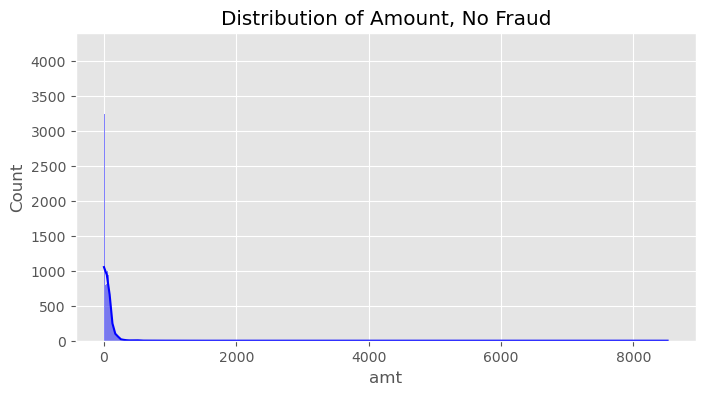

In [393]:
plt.figure(figsize=(8, 4))
sns.histplot(df_safe['amt'], kde=True, color='blue')
plt.title(f'Distribution of Amount, No Fraud')
plt.show()

In [394]:
df_fraud['amt'].describe()

count    107.000
mean     519.221
std      393.892
min        3.150
25%      138.295
50%      378.560
75%      900.815
max     1139.970
Name: amt, dtype: float64

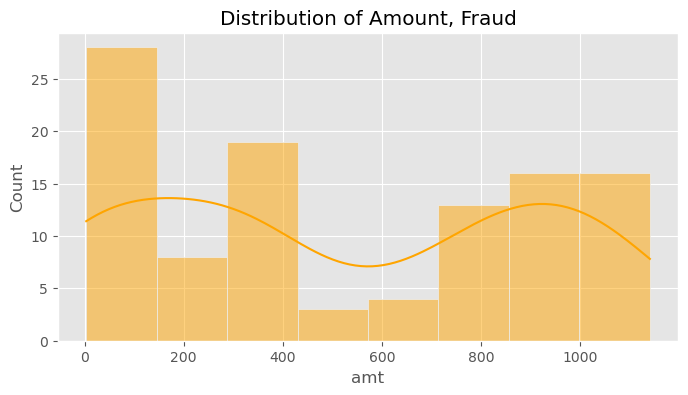

In [395]:
plt.figure(figsize=(8, 4))
sns.histplot(df_fraud['amt'], kde=True, color = "orange")
plt.title(f'Distribution of Amount, Fraud')
plt.show()

Average fraud transaction is 519.22 in comparison to non-fraud average of 66.54. The majority of non-fraud transactions are under $47 while fraud is higher amounts

## Distance_KM

In [398]:
df_safe['distance_km'].describe()

count   27678.000
mean       76.418
std        28.925
min         0.148
25%        55.700
50%        78.556
75%        98.668
max       148.395
Name: distance_km, dtype: float64

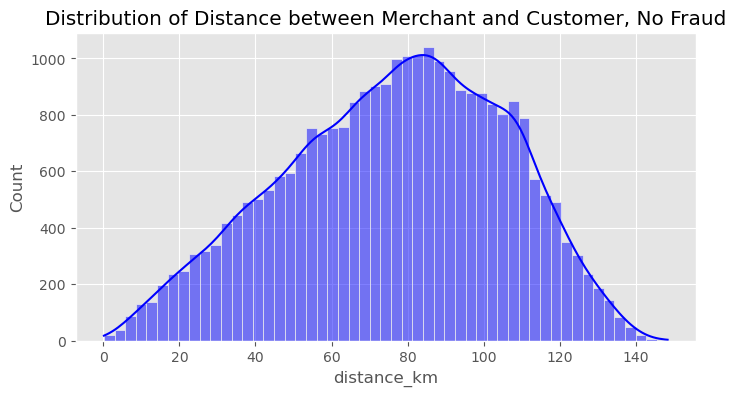

In [399]:
plt.figure(figsize=(8, 4))
sns.histplot(df_safe['distance_km'], kde=True, color='blue')
plt.title(f'Distribution of Distance between Merchant and Customer, No Fraud')
plt.show()

In [400]:
df_fraud['distance_km'].describe()

count   107.000
mean     74.704
std      28.697
min      15.061
25%      54.903
50%      77.960
75%      96.390
max     127.969
Name: distance_km, dtype: float64

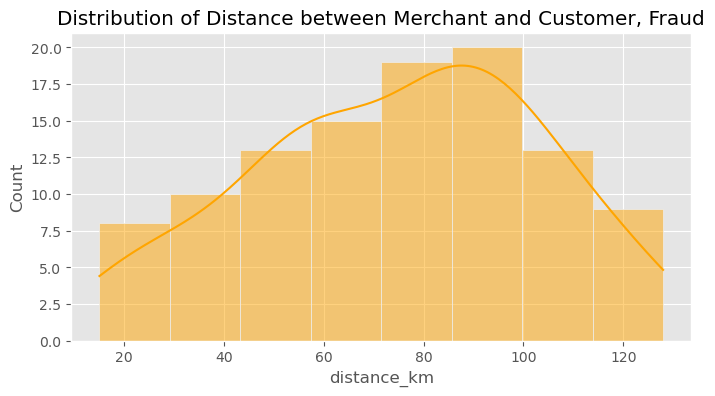

In [401]:
plt.figure(figsize=(8, 4))
sns.histplot(df_fraud['distance_km'], kde=True, color = "orange")
plt.title(f'Distribution of Distance between Merchant and Customer, Fraud')
plt.show()

The distribution of distance for non-fraud appears to be somewhat normally distributed. Fraud seems concentrated at lower distances and a right-skew with a concentration at the 70-90 range.

## Generations

<Figure size 800x400 with 0 Axes>

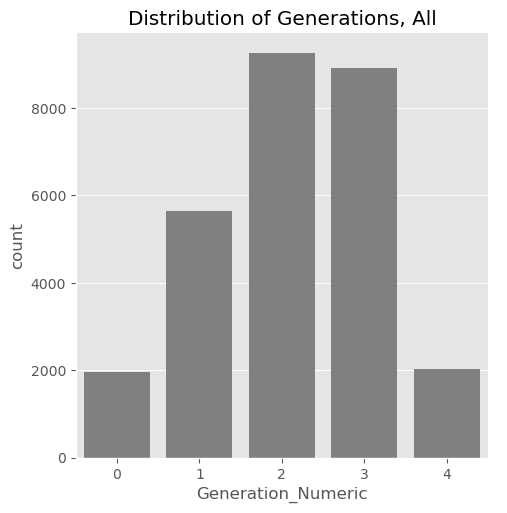

In [404]:
plt.figure(figsize=(8, 4))
sns.catplot(data = df2, x = "Generation_Numeric", kind ="count", color = 'grey')
plt.title(f'Distribution of Generations, All')
plt.show()

<Figure size 800x400 with 0 Axes>

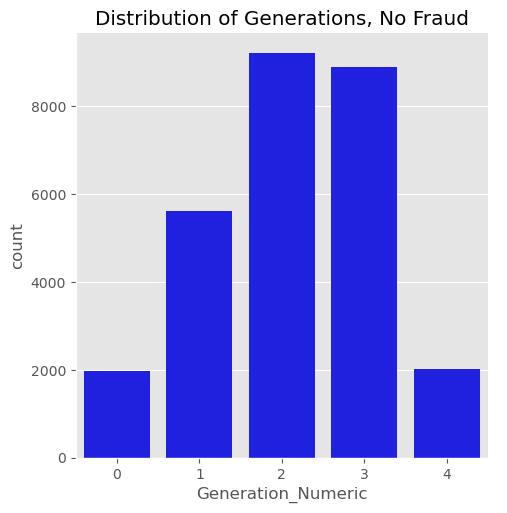

In [405]:
plt.figure(figsize=(8, 4))
sns.catplot(data = df_safe, x = "Generation_Numeric", kind ="count", color = 'blue')
plt.title(f'Distribution of Generations, No Fraud')
plt.show()

<Figure size 800x400 with 0 Axes>

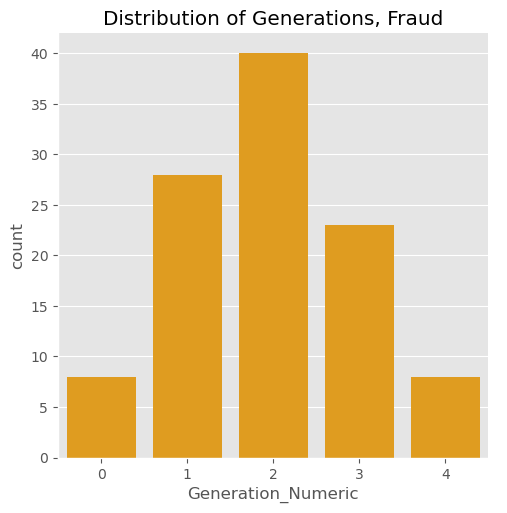

In [406]:
plt.figure(figsize=(8, 4))
sns.catplot(data = df_fraud, x = "Generation_Numeric", kind ="count", color = 'orange')
plt.title(f'Distribution of Generations, Fraud')
plt.show()

In [407]:
#get original generation counts
o0 = df2[df2['Generation_Numeric'] == 0].shape[0]
o1 = df2[df2['Generation_Numeric'] == 1].shape[0]
o2 = df2[df2['Generation_Numeric'] == 2].shape[0]
o3 = df2[df2['Generation_Numeric'] == 3].shape[0]
o4 = df2[df2['Generation_Numeric'] == 4].shape[0]
o5 = df2[df2['Generation_Numeric'] == 5].shape[0]
#get fraud generation counts
f0 = df_fraud[df_fraud['Generation_Numeric'] == 0].shape[0]
f1 = df_fraud[df_fraud['Generation_Numeric'] == 1].shape[0]
f2 = df_fraud[df_fraud['Generation_Numeric'] == 2].shape[0]
f3 = df_fraud[df_fraud['Generation_Numeric'] == 3].shape[0]
f4 = df_fraud[df_fraud['Generation_Numeric'] == 4].shape[0]
f5 = df_fraud[df_fraud['Generation_Numeric'] == 5].shape[0]
#get fraud %
fp0 = (f0 / o0 * 100) if o0 != 0 else 0
fp1 = (f1 / o1 * 100) if o1 != 0 else 0
fp2 = (f2 / o2 * 100) if o2 != 0 else 0
fp3 = (f3 / o3 * 100) if o3 != 0 else 0
fp4 = (f4 / o4 * 100) if o4 != 0 else 0
fp5 = (f5 / o5 * 100) if o5 != 0 else 0


gen_fraud = pd.DataFrame({
    'Generation ID': ['0', '1', '2', '3', '4', '5'],
    'Generation': ["Silent", "Baby Boomer", "Gen X", "Millennial", "Gen Z", "Gen Alpha"],
    'Total Count': [o0, o1, o2, o3, o4, o5],
    'Total Fraud': [f0, f1, f2, f3, f4, f5],
    'Percent Fraud': [fp0, fp1, fp2, fp3, fp4, fp5]
})

gen_fraud

,Generation ID,Generation,Total Count,Total Fraud,Percent Fraud
0,0,Silent,1968,8,0.407
1,1,Baby Boomer,5640,28,0.496
2,2,Gen X,9251,40,0.432
3,3,Millennial,8912,23,0.258
4,4,Gen Z,2014,8,0.397
5,5,Gen Alpha,0,0,0.000


The distribution of generations in the original dataset is 33% Generation X closely followed by 32% millennial generation and 20% baby boomer. Among the fraudulet transactions the generations most hit was Gen X at 37%, followed by baby boomers (26%) and then millennials (28%). However when looking at the likelihood of fraud within the generations themselves you see an interesting story. Millennials are the least likely generation to experience fraud. The Silent Generation, Baby Boomers, Gen X and Gen Z alre are within 40-50%. This points to educational opportunities

## Time 

### Is Weekend

<Figure size 800x400 with 0 Axes>

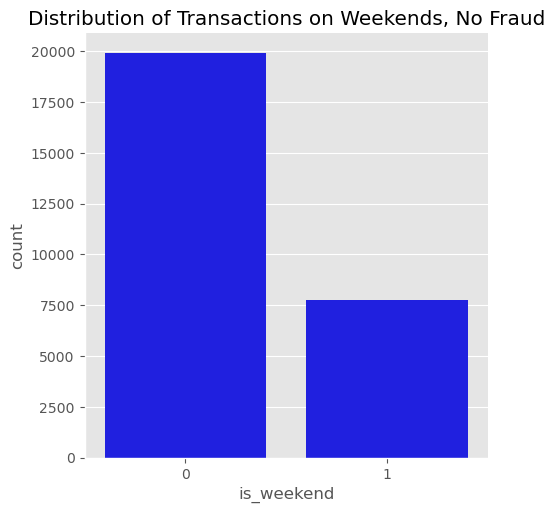

In [411]:
plt.figure(figsize=(8, 4))
sns.catplot(data = df_safe, x = "is_weekend", kind ="count", color = 'blue')
plt.title(f'Distribution of Transactions on Weekends, No Fraud')
plt.show()

<Figure size 800x400 with 0 Axes>

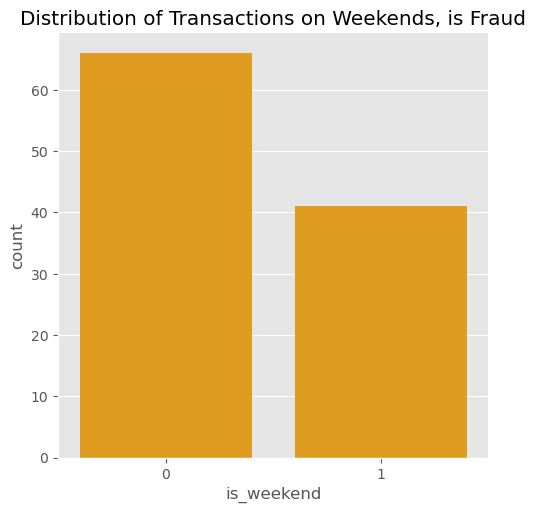

In [412]:
plt.figure(figsize=(8, 4))
sns.catplot(data = df_fraud, x = "is_weekend", kind ="count", color = 'orange')
plt.title(f'Distribution of Transactions on Weekends, is Fraud')
plt.show()

### Time of Day

<Figure size 800x400 with 0 Axes>

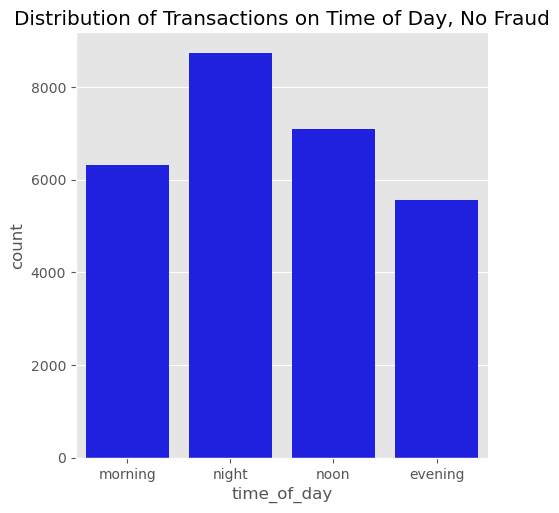

In [414]:
plt.figure(figsize=(8, 4))
sns.catplot(data = df_safe, x = "time_of_day", kind ="count", color = 'blue')
plt.title(f'Distribution of Transactions on Time of Day, No Fraud')
plt.show()

<Figure size 800x400 with 0 Axes>

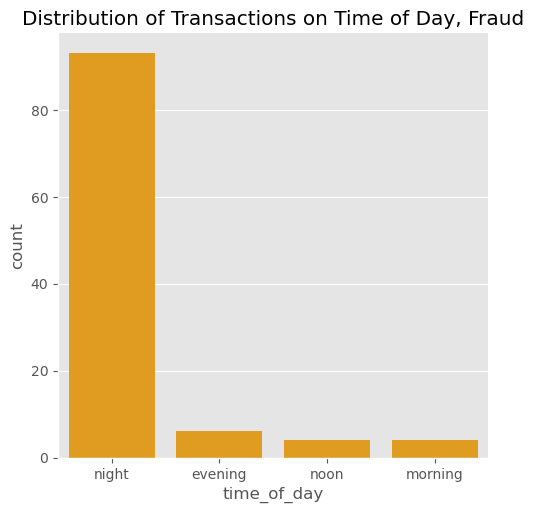

In [415]:
plt.figure(figsize=(8, 4))
sns.catplot(data = df_fraud, x = "time_of_day", kind ="count", color = 'orange')
plt.title(f'Distribution of Transactions on Time of Day, Fraud')
plt.show()

A high distribution of fraud occurs at night.

## Spend Category

<Figure size 800x400 with 0 Axes>

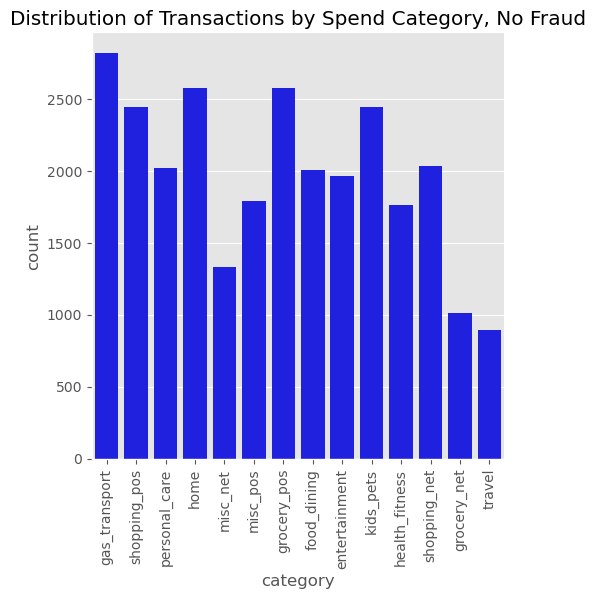

In [418]:
plt.figure(figsize=(8, 4))
sns.catplot(data = df_safe, x = "category", kind ="count", color = 'blue')
plt.title(f'Distribution of Transactions by Spend Category, No Fraud')
plt.xticks(rotation=90)
plt.show()

In [419]:
df_safe['category'].value_counts()

category
gas_transport     2816
home              2578
grocery_pos       2577
kids_pets         2446
shopping_pos      2441
shopping_net      2033
personal_care     2018
food_dining       2008
entertainment     1964
misc_pos          1793
health_fitness    1766
misc_net          1335
grocery_net       1009
travel             894
Name: count, dtype: int64

<Figure size 800x400 with 0 Axes>

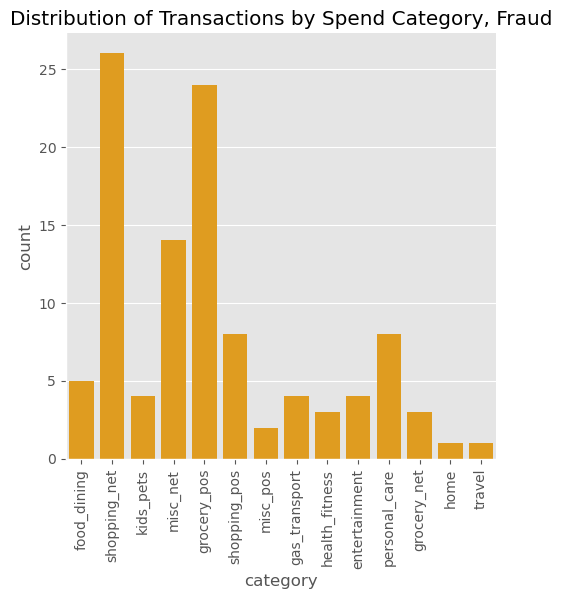

In [420]:
plt.figure(figsize=(8, 4))
sns.catplot(data = df_fraud, x = "category", kind ="count", color = 'orange')
plt.title(f'Distribution of Transactions by Spend Category, Fraud')
plt.xticks(rotation = 90)
plt.show()

In [421]:
df_fraud['category'].value_counts()

category
shopping_net      26
grocery_pos       24
misc_net          14
shopping_pos       8
personal_care      8
food_dining        5
kids_pets          4
gas_transport      4
entertainment      4
health_fitness     3
grocery_net        3
misc_pos           2
home               1
travel             1
Name: count, dtype: int64

The bigest categories of fraud are online shopping, misc online and grocery.

## Gender

<Figure size 800x400 with 0 Axes>

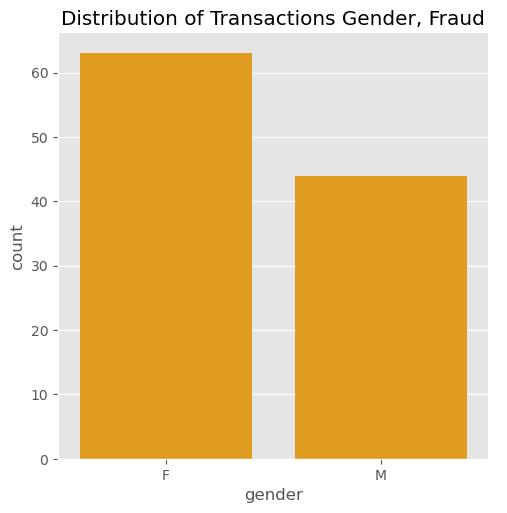

In [424]:
plt.figure(figsize=(8, 4))
sns.catplot(data = df_fraud, x = "gender", kind ="count", color = 'orange')
plt.title(f'Distribution of Transactions Gender, Fraud')
plt.show()

In [425]:
female_total = df2[df2['gender'] == 'F'].shape[0]
male_total = df2[df2['gender'] == 'M'].shape[0]
female_fraud = df_fraud[df_fraud['gender'] == 'F'].shape[0]
male_fraud = df_fraud[df_fraud['gender'] == 'M'].shape[0]
female_fraud_percent = (female_fraud/female_total)*100 if female_total != 0 else 0
male_fraud_percent = (male_fraud/male_total)*100 if male_total != 0 else 0

mf_fraud = pd.DataFrame({
    'Gender': ["F", "M"], 
    'Total Count': [female_total, male_total],
    'Fraud Count': [female_fraud, male_fraud], 
    'Fraud %': [female_fraud_percent, male_fraud_percent]
})

mf_fraud

,Gender,Total Count,Fraud Count,Fraud %
0,F,15252,63,0.413
1,M,12533,44,0.351


There is a slightly higher likelihood of fraud occuring among women vs men. 

## City Population

<Figure size 800x400 with 0 Axes>

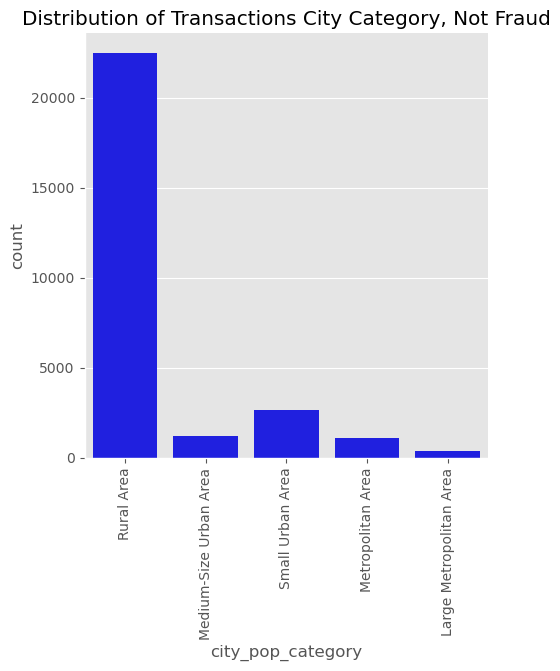

In [428]:
plt.figure(figsize=(8, 4))
sns.catplot(data = df_safe, x = "city_pop_category", kind ="count", color = 'blue')
plt.title(f'Distribution of Transactions City Category, Not Fraud')
plt.xticks(rotation = 90)
plt.show()

<Figure size 800x400 with 0 Axes>

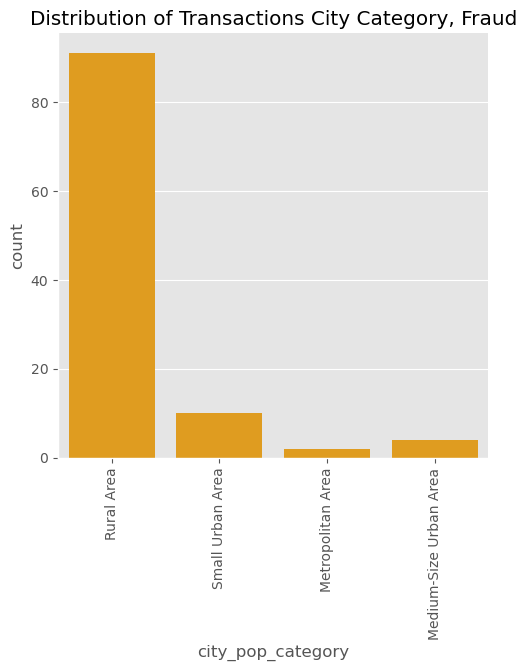

In [429]:
plt.figure(figsize=(8, 4))
sns.catplot(data = df_fraud, x = "city_pop_category", kind ="count", color = 'orange')
plt.title(f'Distribution of Transactions City Category, Fraud')
plt.xticks(rotation = 90)
plt.show()

In [430]:
df_fraud['city_pop_category'].value_counts()

city_pop_category
Rural Area                91
Small Urban Area          10
Medium-Size Urban Area     4
Metropolitan Area          2
Name: count, dtype: int64

In [431]:
r_total = df2[df2['city_pop_category'] == 'Rural Area'].shape[0]
su_total = df2[df2['city_pop_category'] == 'Small Urban Area'].shape[0]
med_total = df2[df2['city_pop_category'] == 'Medium-Size Urban Area'].shape[0]
metro_total = df2[df2['city_pop_category'] == 'Metropolitan Area'].shape[0]

r_fraud = df_fraud[df_fraud['city_pop_category'] == 'Rural Area'].shape[0]
su_fraud = df_fraud[df_fraud['city_pop_category'] == 'Small Urban Area'].shape[0]
med_fraud = df_fraud[df_fraud['city_pop_category'] == 'Medium-Size Urban Area'].shape[0]
metro_fraud = df_fraud[df_fraud['city_pop_category'] == 'Metropolitan Area'].shape[0]


r_per = (r_fraud/r_total)*100
su_per = (su_fraud/su_total)*100
med_per = (med_fraud/med_total)*100
metro_per = (metro_fraud/metro_total)*100

city_fraud = pd.DataFrame({
    'City Pop Category': ["Rural Area", "Small Urban Area", "Medium-Size Urban Area", "Metropolitan Area"], 
    'Total Count': [r_total, su_total,med_total, metro_total],
    'Fraud Count': [r_fraud, su_fraud, med_fraud, metro_fraud], 
    'Fraud %': [r_per, su_per,med_per, metro_per]
})

city_fraud

,City Pop Category,Total Count,Fraud Count,Fraud %
0,Rural Area,22559,91,0.403
1,Small Urban Area,2626,10,0.381
2,Medium-Size Urban Area,1174,4,0.341
3,Metropolitan Area,1080,2,0.185


Majority of the dataset is in rural areas, but the proportion of fraud seems somewhat evenly distributed between rural, small urban and medium sized urban.There is not much representation of metro.

## Prep Data for Modeling

### Convert Catagorical to Dummy Variables

https://www.geeksforgeeks.org/python-pandas-get_dummies-method/

In [435]:
# Displaying all columns in the dataset df1 along with their data types
all_columns_info = df2.dtypes
print(all_columns_info)

category               object
amt                   float64
gender                 object
is_fraud                int64
distance_km           float64
Generation_Numeric      int64
city_pop_category      object
day_of_week             int32
hour_of_day             int32
month                   int32
quarter                 int32
time_of_day            object
is_weekend              int64
dtype: object


In [436]:
# One-hot encoding for the specified categorical column
df3 = pd.get_dummies(df2,
                     columns=['category', 'city_pop_category', 'gender', 'time_of_day'],
                     prefix=['category', 'city_pop_category', 'gender', 'time_of_day'],
                     drop_first=True)  # Dropping the first category to avoid multicollinearity

# Convert any boolean columns in df3 to integers
bool_cols = df3.select_dtypes(include=[bool]).columns  # Find any boolean columns
df3[bool_cols] = df3[bool_cols].astype(int)  # Convert them to integers

# Verify the data types in the new DataFrame
print(df3.dtypes)

# Display the first few rows of the resulting DataFrame
df3.head()

amt                                         float64
is_fraud                                      int64
distance_km                                 float64
Generation_Numeric                            int64
day_of_week                                   int32
hour_of_day                                   int32
month                                         int32
quarter                                       int32
is_weekend                                    int64
category_food_dining                          int32
category_gas_transport                        int32
category_grocery_net                          int32
category_grocery_pos                          int32
category_health_fitness                       int32
category_home                                 int32
category_kids_pets                            int32
category_misc_net                             int32
category_misc_pos                             int32
category_personal_care                        int32
category_sho

,amt,is_fraud,distance_km,Generation_Numeric,day_of_week,hour_of_day,month,quarter,is_weekend,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,city_pop_category_Medium-Size Urban Area,city_pop_category_Metropolitan Area,city_pop_category_Rural Area,city_pop_category_Small Urban Area,gender_M,time_of_day_morning,time_of_day_night,time_of_day_noon
0,50.420,0,60.200,1,1,5,12,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,39.470,0,46.722,2,0,2,6,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0
2,8.160,0,93.483,3,0,15,12,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
3,25.480,0,82.612,3,3,23,12,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,5.710,0,72.611,2,5,11,6,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0


### Handling imbalanced dataset (target variable) by using SMOTE library

https://www.geeksforgeeks.org/smote-for-imbalanced-classification-with-python/#smote-synthetic-minority-oversampling-technique

In [438]:
# Separate features and target variable
X = df3.drop('is_fraud', axis=1)  # Drop the target variable
y = df3['is_fraud']                # Target variable

# Convert categorical variables to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Check for missing values and handle them
if X.isnull().sum().any():
    print("Missing values detected in features.")
    X.fillna(X.mean(), inplace=True)  # Fill NaN values with mean for numeric features

# Ensure target variable is of integer type
y = y.astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test = scaler.transform(X_test)  # Apply the same transformation to the test set

# Check class distribution
print("Before SMOTE:")
print(y_train.value_counts())
print("\nAfter SMOTE:")
print(pd.Series(y_resampled).value_counts())

Before SMOTE:
is_fraud
0    22142
1       86
Name: count, dtype: int64

After SMOTE:
is_fraud
0    22142
1    22142
Name: count, dtype: int64


Normalization

In [440]:
# Set the option to display all columns
pd.set_option('display.max_columns', None)

# Display the first 5 rows of the dataframe with all columns visible
pd.DataFrame(X_resampled).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,-0.477,1.492,-0.922,1.653,-0.339,-0.657,-0.501,2.011,-0.247,-0.250,-0.137,2.452,-0.189,-0.220,-0.219,-0.271,-0.183,-0.218,-0.380,-0.230,-0.129,-0.148,-0.141,0.574,-0.243,1.452,2.775,-1.037,-0.383
1,-0.593,0.626,-0.922,-0.950,-0.087,0.478,1.208,-0.497,-0.247,-0.250,-0.137,-0.408,-0.189,4.551,-0.219,-0.271,-0.183,-0.218,-0.380,-0.230,-0.129,-0.148,7.106,-1.742,-0.243,1.452,-0.360,-1.037,2.614
2,-0.648,1.660,0.110,1.133,-0.718,1.613,1.208,2.011,-0.247,-0.250,7.308,-0.408,-0.189,-0.220,-0.219,-0.271,-0.183,-0.218,-0.380,-0.230,-0.129,-0.148,-0.141,0.574,-0.243,1.452,2.775,-1.037,-0.383
3,-0.321,0.455,1.142,1.653,-1.728,1.613,1.208,2.011,-0.247,-0.250,-0.137,2.452,-0.189,-0.220,-0.219,-0.271,-0.183,-0.218,-0.380,-0.230,-0.129,-0.148,-0.141,0.574,-0.243,-0.689,-0.360,0.965,-0.383
4,-0.649,1.778,0.110,-0.950,0.923,-0.657,-0.501,-0.497,4.056,-0.250,-0.137,-0.408,-0.189,-0.220,-0.219,-0.271,-0.183,-0.218,-0.380,-0.230,-0.129,6.758,-0.141,-1.742,-0.243,-0.689,-0.360,0.965,-0.383


# Data Modeling

## Logistic Regression

Confusion Matrix:
[[5248  288]
 [   8   13]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      5536
           1       0.04      0.62      0.08        21

    accuracy                           0.95      5557
   macro avg       0.52      0.78      0.53      5557
weighted avg       0.99      0.95      0.97      5557



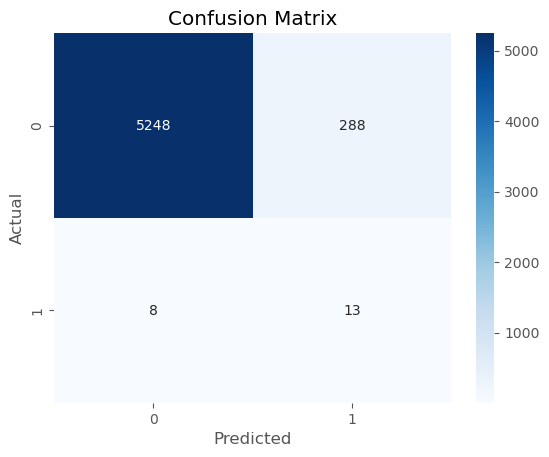

In [443]:
# Logistic Regression with class_weight='balanced'
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_resampled, y_resampled)

# Predictions on the test set
y_pred = model.predict(X_test)

# Confusion Matrix and Classification Report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualizing the Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

High Accuracy: The model has a high accuracy (95%) primarily due to the correct prediction of non-fraud cases, which dominate the dataset. However, the model struggles to correctly identify fraud cases, as indicated by the very low precision (0.04) for class 1 (fraud).


Precision vs. Recall for Fraud: The recall for fraud cases (0.62) is better than the precision (0.04), meaning that while the model captures a decent portion of actual fraud cases, it misclassifies many non-fraud cases as fraud, leading to a low precision.


## XGBoost

In [446]:
# Calculate scale_pos_weight (ratio of negative to positive examples)
neg, pos = np.bincount(y_train)  # For X_resampled and y_resampled use for SMOTE
scale_pos_weight = neg / pos

# XGBoost Classifier
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss')
xgb_model.fit(X_resampled, y_resampled)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluation
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred))

XGBoost Confusion Matrix:
[[5501   35]
 [   6   15]]

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5536
           1       0.30      0.71      0.42        21

    accuracy                           0.99      5557
   macro avg       0.65      0.85      0.71      5557
weighted avg       1.00      0.99      0.99      5557



High Overall Accuracy: The accuracy is significantly high (99%), indicating that the model performs very well on the dataset.

Improved Fraud Detection: Compared to Logistic Regression, XGBoost shows a significant improvement in fraud detection (class 1). The recall for fraud cases is now 0.71 (71%), meaning the model captures more actual fraud cases than the Logistic Regression model.

Precision for Fraud Cases: Although precision is still relatively low for fraud cases (0.30), it is an improvement over the Logistic Regression model. This shows that while the model predicts more fraud cases, some of the predictions are still incorrect (false positives).

Balanced Performance: XGBoost strikes a good balance between precision and recall for both classes, which is crucial for fraud detection, where false negatives (missed fraud cases) are more costly than false positives.

Fraud Detection using XGBoost and Deep Learning : https://medium.com/@f2005636/fraud-detection-using-xgboost-and-deep-learning-c8e1ce6c5c32

## LightGBM

In [450]:
# LightGBM Dataset
lgb_train = lgb.Dataset(X_resampled, label=y_resampled)

# LightGBM Parameters
lgb_params = {
    'objective': 'binary',
    'is_unbalance': True,  # Handles class imbalance
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt'
}

# Train the model
lgb_model = lgb.train(lgb_params, lgb_train, num_boost_round=100)

# Predictions
y_pred = (lgb_model.predict(X_test) > 0.5).astype(int)

# Evaluation
print("LightGBM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nLightGBM Classification Report:")
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 22142, number of negative: 22142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 44284, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Confusion Matrix:
[[5514   22]
 [   6   15]]

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5536
           1       0.41      0.71      0.52        21

    accuracy                           0.99      5557
   macro avg       0.70      0.86      0.76      5557
weighted avg       1.00      0.99      1.00      5557



Fighting Fraud at the Speed of LightGBM : https://feedzai.com/blog/lightgbm/

Strong Non-Fraud Detection: The model performs perfectly on class 0 (non-fraud), achieving a precision, recall, and F1-score of 1.00.

Fraud Detection Performance: LightGBM shows a moderate improvement in fraud detection compared to Logistic Regression and XGBoost. The recall remains consistent with XGBoost (0.71), but the precision has increased to 0.41, meaning more fraud cases are correctly identified as fraud without too many false positives.

Balanced Performance: With a higher F1-score for fraud (0.52) compared to XGBoost (0.42), LightGBM provides better overall balance in fraud detection while maintaining high accuracy across both classes.


## CatBoost

In [454]:
# CatBoost Classifier
catboost_model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, scale_pos_weight=scale_pos_weight, verbose=0)
catboost_model.fit(X_resampled, y_resampled)

# Predictions
y_pred = catboost_model.predict(X_test)

# Evaluation
print("CatBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nCatBoost Classification Report:")
print(classification_report(y_test, y_pred))

CatBoost Confusion Matrix:
[[4554  982]
 [   3   18]]

CatBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      5536
           1       0.02      0.86      0.04        21

    accuracy                           0.82      5557
   macro avg       0.51      0.84      0.47      5557
weighted avg       1.00      0.82      0.90      5557



CatBoost for Fraud Detection in Financial Transactions https://ieeexplore.ieee.org/document/9342475

High Recall for Fraud Detection: The model performs very well in identifying actual fraud cases, with a recall of 0.86. This means 86% of the actual fraud cases were successfully detected.

 Low Precision for Fraud: The precision for fraud is very low (0.02), indicating that the model predicts many non-fraud cases as fraud, resulting in a large number of false positives.

Performance on Non-Fraud Cases: The model achieves perfect precision for non-fraud cases (1.00) but only captures 82% of the actual non-fraud cases (recall of 0.82).

** In this specific fraud detection case, CatBoos is the best-performing model as it has the least amount of false negatives. Prioritizing recall, the model is correctly identifying approximately 86% of actual fraud cases.** 